# TRABAJO FINAL

## Descripción del trabajo

En este trabajo vamos a hacer un modelo, el cual recibe como input diferentes datos médicos y de trabajo de diferentes pacientes y tiene como output un puntaje de riesgo de enfermedad cardiovascular. Vamos a utilizar redes del tipo feedforward.

## Cargamos librerías y definimos funciones

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import optimizers
from keras.callbacks import Callback

class DynamicLearningRate(Callback):                                    #Learning rate que aumenta cuando el modelo no aprende. No funcionó para nada.
    def __init__(self, initial_learning_rate, patience=3, factor=2):
        super(DynamicLearningRate, self).__init__()
        self.learning_rate = initial_learning_rate
        self.patience = patience
        self.factor = factor
        self.best_loss = float('inf')
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if current_loss is None:
            return

        if current_loss < self.best_loss:
            self.best_loss = current_loss
            self.wait = 0
        else:
            self.wait += 1

        if self.wait >= self.patience:
            new_lr = self.learning_rate * self.factor
            self.learning_rate = new_lr
            tf.keras.backend.set_value(self.model.optimizer.learning_rate, new_lr)
            print(f"\nEpoch {epoch+1}: Learning rate increased to {new_lr}.")
            self.wait = 0

class LRSchedule(optimizers.schedules.LearningRateSchedule):            #Learning rate que disminuye cada n épocas. No funcionó para nada.

    def __init__(self, initial_learning_rate):
        self.initial_learning_rate = initial_learning_rate

    def __call__(self, step):
        reduction_factor = 0.1
        steps_per_reduction = 50
        return self.initial_learning_rate * (reduction_factor ** tf.floor(step / steps_per_reduction))
    
class PrintEveryN(Callback):                                            #Función para que los modelos printien los accuracys y losses cada n epochs.
    def __init__(self, n):
        self.n = n

    def on_epoch_end(self, epoch, logs=None):
        if ((epoch + 1) % self.n == 0) or (epoch==0):
            print(f"Epoch {epoch + 1}: loss = {logs['loss']}, val_loss = {logs['val_loss']}, acc={logs['accuracy']}, val_acc = {logs['val_accuracy']}")

def format(axs):                                                        #Estilo de las gráficas.
    try:
        for ax in axs.flat:
            ax.grid(color='w',linestyle='-',linewidth=1,zorder=0)
            ax.set_axisbelow(True)
            ax.set_zorder(1)
            ax.tick_params(axis='both', which='major', direction='in',
                            labelsize=15, length=10, width=2)
            ax.tick_params(axis='both', which='minor', direction='in',
                            labelsize=15, length=4, width=1)
            ax.set_facecolor('#d8dcd6')
    except:
        axs.grid(color='w',linestyle='-',linewidth=1,zorder=0)
        axs.set_axisbelow(True)
        axs.set_zorder(1)
        axs.tick_params(axis='both', which='major', direction='in',
                        labelsize=15, length=10, width=2)
        axs.tick_params(axis='both', which='minor', direction='in',
                        labelsize=15, length=4, width=1)
        axs.set_facecolor('#d8dcd6')

## Lectura, análisis y limpieza de datos
Ahora procedemos a leer el archivo

In [3]:
arch = pd.read_csv(filepath_or_buffer='acvdata.csv')

Vamos a verlo por encima.

In [4]:
arch.info()
arch.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16361 entries, 0 to 16360
Data columns (total 54 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   16361 non-null  int64  
 1   Fecha                        16361 non-null  object 
 2   Hora                         16361 non-null  object 
 3   Edad                         16361 non-null  int64  
 4   Sexo                         16361 non-null  object 
 5   Ocupaci.n                    16348 non-null  object 
 6   Horario.Trabajo              11396 non-null  object 
 7   Sobrepeso                    16361 non-null  object 
 8   Obeso                        16361 non-null  object 
 9   Pat..Tiroidea                16361 non-null  object 
 10  Dislipemia                   16361 non-null  object 
 11  Hiperuricemia                16361 non-null  object 
 12  Cardiop..Isqu.               16361 non-null  object 
 13  Tabaquismo      

Unnamed: 0          Edad  Cantidad_Dia   Anios_Fuma.  Anios_Libre.  \
count  16361.000000  16361.000000  16361.000000  16361.000000  16361.000000   
mean    8181.000000     52.952326      4.103050      8.112035      3.866634   
std     4723.158212      8.976167      7.822059     12.990380      8.281770   
min        1.000000      1.000000      0.000000      0.000000      0.000000   
25%     4091.000000     47.000000      0.000000      0.000000      0.000000   
50%     8181.000000     53.000000      0.000000      0.000000      0.000000   
75%    12271.000000     59.000000      5.000000     19.000000      1.000000   
max    16361.000000     90.000000    150.000000     62.000000     63.000000   

              Peso.        Talla.  Contorno_Cintura.  TA_Brazo_Dcho.1  \
count  16361.000000  16361.000000       16361.000000     16361.000000   
mean      79.051368      1.656036          95.793647       129.976591   
std       16.100637      0.091103          13.900569        21.399084   
min        0.000000      0.000000           0.000000         0.000000   
25%       68.000000      1.590000          87.000000       120.000000   
50%       78.000000      1.660000          96.000000       130.000000   
75%       88.500000      1.720000         104.000000       140.000000   
max      188.000000      1.980000         210.000000       260.000000   

       TA_Brazo_Dcho.2  X2..TA_Brazo_Dcho.1  X2..TA_Brazo_Dcho.2  \
count     16361.000000         16361.000000         16361.000000   
mean         81.247601           128.604914            80.306277   
std          14.409900            20.423224            13.820514   
min           0.000000             0.000000             0.000000   
25%          70.000000           120.000000            70.000000   
50%          80.000000           130.000000            80.000000   
75%          90.000000           140.000000            90.000000   
max         190.000000           250.000000           170.000000   

       Glucemia_Ayuno.  Glucemia_PostPrandial.  Colesterol_Ayuno.  \
count     16361.000000            16361.000000       16361.000000   
mean         40.706130               58.538781         196.930933   
std          51.375074               59.092879          39.341224   
min           0.000000                0.000000           0.000000   
25%           0.000000                0.000000         165.000000   
50%           0.000000               78.000000         194.000000   
75%          86.000000               95.000000         222.000000   
max         451.000000              518.000000         400.000000   

           Puntaje.   Porcentaje.  Score.Bajo.Riesgo..Europeo.  \
count  16361.000000  16361.000000                 16361.000000   
mean      10.710592      5.792678                     1.675753   
std        4.886691      5.737753                     2.476107   
min       -9.000000     -1.000000                     0.000000   
25%        8.000000      1.000000                     0.000000   
50%       11.000000      4.000000                     1.000000   
75%       14.000000     10.000000                     2.000000   
max       25.000000     30.000000                    26.000000   

       Score.Alto.Riesgo  
count       16361.000000  
mean            3.209706  
std             4.432856  
min             0.000000  
25%             1.000000  
50%             1.000000  
75%             4.000000  
max            47.000000

Primero vamos a limpiar un poco el archivo:
- Sacamos cosas que son claramente irrelevantes, como la fecha y hora de llegada al hospital.
- Sacamos columnas que pueden ser deducidas de otras (las obvias, después vamos a analizar correlaciones), como pueden ser sobrepeso y obesidad que con la estatura y peso pueden ser deducidas.
- Caso especial, vamos a sacar las estadísticas específicas sobre años fumando y cantidad de cigarrillos porque están muy incompletas.
- Vamos a hacer numéricas algunas variables que son categóricas, como el sexo y todos los booleanos.

In [21]:
arch1 = arch.drop(['Fecha','Hora','IMC.','Unnamed: 0','Horario.Trabajo','Sobrepeso','Ocupaci.n','Obeso','Ex_Fumador','Cantidad_Dia','Anios_Fuma.','Anios_Libre.','DBT_Padre.','Colesterol_Padre.','HTA_Padre.','Obesidad_Padre.','Tabaquismo_Padre.','DBT_Madre.','Colesterol_Madre.','HTA_Madre.','Obesidad_Madre.','Tabaquismo_Madre.','Derivacion.','Cargado.','Encuestador.','Puntaje.','Porcentaje.'],axis=1)
arch1 = arch1.drop([38,6726,7285]) #Estos son un par de datos que tenian varias cosas mal
arch1 = arch1.replace({'M':0, 'F':1})
arch1 = arch1.replace({'NO': 3, 'SI': 0,'NS': 1,'EF': 0}) #Les pongo ese orden para que tenga un poco de sentido, mientras mas alto el número mejor para el paciente
arch1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16358 entries, 0 to 16360
Data columns (total 27 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Edad                         16358 non-null  int64  
 1   Sexo                         16358 non-null  int64  
 2   Pat..Tiroidea                16358 non-null  int64  
 3   Dislipemia                   16358 non-null  int64  
 4   Hiperuricemia                16358 non-null  int64  
 5   Cardiop..Isqu.               16358 non-null  int64  
 6   Tabaquismo                   16358 non-null  int64  
 7   HTA.                         16358 non-null  int64  
 8   Tratado.                     16358 non-null  int64  
 9   ACV.                         16358 non-null  int64  
 10  Diabetes.                    16358 non-null  int64  
 11  Macrosomia.                  16358 non-null  int64  
 12  Diabetes_Gest.               16358 non-null  int64  
 13  Diabetes_Tratada

Ahora vamos a ver las correlaciones

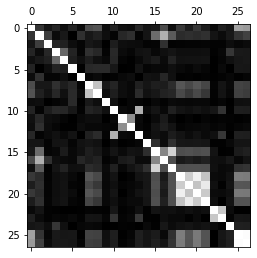

In [22]:
corrmat=arch1.corr()
plt.matshow(np.abs(corrmat),cmap='gray')
plt.show()

Vamos a eliminar las cosas con altas (>0.75) correlaciones entre ellas. Tambien hay un par de columnas que tienen el patrón "Enfermedad", "Tratado". Ya hicimos que los SI sean 0 y los NO 3, vamos a agregar la opción de 2 si la tuvieron y fueron tratados y eliminamos la columna del tratamiento. También vamos a asumir que los que no saben si fueron tratados, no fueron tratados y que los que fueron tratados pero no saben si tenian la enfermedad, si la tenían.

In [7]:
arch1['Diabetes.'] = arch1.apply(lambda row: 2 if (row['Diabetes.'] == 0 or row['Diabetes.'] == 1) and row['Diabetes_Tratada.'] == 0 else row['Diabetes.'], axis=1)
arch1=arch1.drop(['Diabetes_Tratada.'],axis=1)

arch1['HTA.'] = arch1.apply(lambda row: 2 if (row['HTA.'] == 0 or row['HTA.'] == 1) and row['Tratado.'] == 0 else row['HTA.'], axis=1)
arch1=arch1.drop(['Tratado.'],axis=1)



In [8]:
arch1=arch1.drop(['TA_Brazo_Dcho.2','X2..TA_Brazo_Dcho.1','X2..TA_Brazo_Dcho.2'],axis=1)
arch1=arch1.drop(['Contorno_Cintura.'],axis=1)
arch1=arch1.drop(['Glucemia_PostPrandial.'],axis=1)


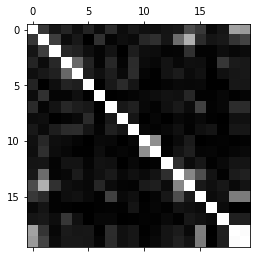

In [9]:
corrmat=arch1.corr()
plt.matshow(np.abs(corrmat),cmap='gray')
plt.show()

Las que tienen baja correlación no son continuas, por lo que nos vamos a quedar con todas las variables. Usamos como target el score de alto riesgo. Ahora separamos los inputs de los outputs.

In [10]:
corr_score = np.abs(arch1.corr()['Score.Alto.Riesgo'])
idxs=corr_score[(corr_score<0.95)].index

X = arch1[idxs]
Y = arch1["Score.Alto.Riesgo"].values

Separamos los train del test.

In [11]:
X_train = X[:13000]
X_test = X[13000:]
Y_train = Y[:13000]
Y_test = Y[13000:]

## Redes con output size = 1


Vamos a probar distintas arquitecturas y cantidad de neuronas con redes que tienen una única neurona de output con el número del score de riesgo.

### Sin capas ocultas

Primero vamos a ver como nos va con lo mas simple que podemos hacer: una red sin capas ocultas

In [31]:
class sin_capa:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(1,input_dim=18,activation='linear'))
        #LRs=LRSchedule(initial_learning_rate=0.1)
        self.model.compile(optimizer=optimizers.Adam(0.001), loss='mse', metrics=['accuracy'])
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000):
        #LRs=DynamicLearningRate(0.001) 
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0,callbacks=[PrintEveryN(100)])
        return history

In [35]:
percept = sin_capa()
history = percept.train(X_train, Y_train, X_test, Y_test, epochs=4000)

Epoch 1: loss = 17085.61328125, val_loss = 16913.271484375, acc=0.186153843998909, val_acc = 0.16438356041908264
Epoch 100: loss = 39.94062805175781, val_loss = 51.07424545288086, acc=0.31676924228668213, val_acc = 0.2918403744697571
Epoch 200: loss = 31.49699592590332, val_loss = 41.414459228515625, acc=0.3260769248008728, val_acc = 0.30136987566947937
Epoch 300: loss = 23.166996002197266, val_loss = 30.381513595581055, acc=0.3308461606502533, val_acc = 0.30256104469299316
Epoch 400: loss = 16.259639739990234, val_loss = 21.088411331176758, acc=0.33761537075042725, val_acc = 0.3052412271499634
Epoch 500: loss = 12.140032768249512, val_loss = 15.686606407165527, acc=0.3392307758331299, val_acc = 0.3111971318721771
Epoch 600: loss = 10.23759937286377, val_loss = 13.23318862915039, acc=0.3577692210674286, val_acc = 0.32162001729011536
Epoch 700: loss = 9.277604103088379, val_loss = 12.000925064086914, acc=0.3765384554862976, val_acc = 0.33353185653686523
Epoch 800: loss = 8.8284015655517

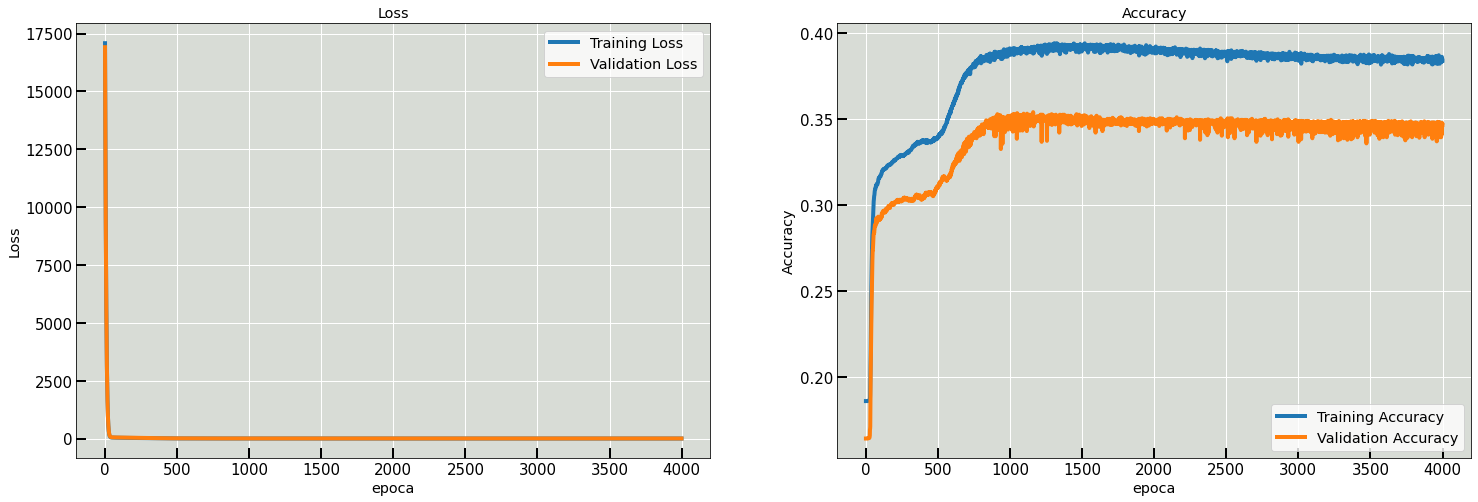

In [36]:
fig, ax = plt.subplots(1,2,figsize=(25,8))
format(ax)
ax[0].set_ylabel('Loss',fontsize='x-large')
ax[0].set_xlabel('epoca',fontsize='x-large')
ax[0].plot(history.history['loss'], label='Training Loss', linewidth=4)
ax[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=4)
ax[0].set_title(r"Loss",fontsize='x-large')
ax[0].legend(fontsize='x-large')

ax[1].set_ylabel('Accuracy',fontsize='x-large')
ax[1].set_xlabel('epoca',fontsize='x-large')
ax[1].plot(history.history['accuracy'], label='Training Accuracy',linewidth=4)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy',linewidth=4)
ax[1].set_title(r"Accuracy",fontsize='x-large')
ax[1].legend(fontsize='x-large')

Vemos que el loss sigue siendo muy alto.

### Una capa oculta

In [37]:
class una_capa:
    def __init__(self, n1):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(1,activation='linear'))
        self.model.compile
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000): 
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=500)])
        return history

Vamos a utilizar varias cantidades de neuronas en esta única capa para ver cual es la mejor opción.

In [38]:
ns = [3,7,15,20]
models=[]
historys=[]
for n1 in ns:
    print (f"n={n1}")
    model = una_capa(n1)
    history = model.train(X_train, Y_train, X_test, Y_test, epochs=4000)
    models.append(model)
    historys.append(history)

n=3
Epoch 1: loss = 5543.130859375, val_loss = 4078.337646484375, acc=0.186153843998909, val_acc = 0.16438356041908264
Epoch 500: loss = 8.61934757232666, val_loss = 11.049362182617188, acc=0.3885384500026703, val_acc = 0.3493150770664215
Epoch 1000: loss = 7.534833908081055, val_loss = 9.84993839263916, acc=0.3895384669303894, val_acc = 0.3487194776535034
Epoch 1500: loss = 7.3944411277771, val_loss = 9.712066650390625, acc=0.38523077964782715, val_acc = 0.34455034136772156
Epoch 2000: loss = 7.359287738800049, val_loss = 9.719071388244629, acc=0.3847692310810089, val_acc = 0.3371054232120514
Epoch 2500: loss = 7.443664073944092, val_loss = 9.586248397827148, acc=0.3824615478515625, val_acc = 0.3466348946094513
Epoch 3000: loss = 7.341792106628418, val_loss = 9.670063018798828, acc=0.3843846023082733, val_acc = 0.34693270921707153
Epoch 3500: loss = 7.337028980255127, val_loss = 9.636242866516113, acc=0.38461539149284363, val_acc = 0.33799880743026733
Epoch 4000: loss = 7.300140857696

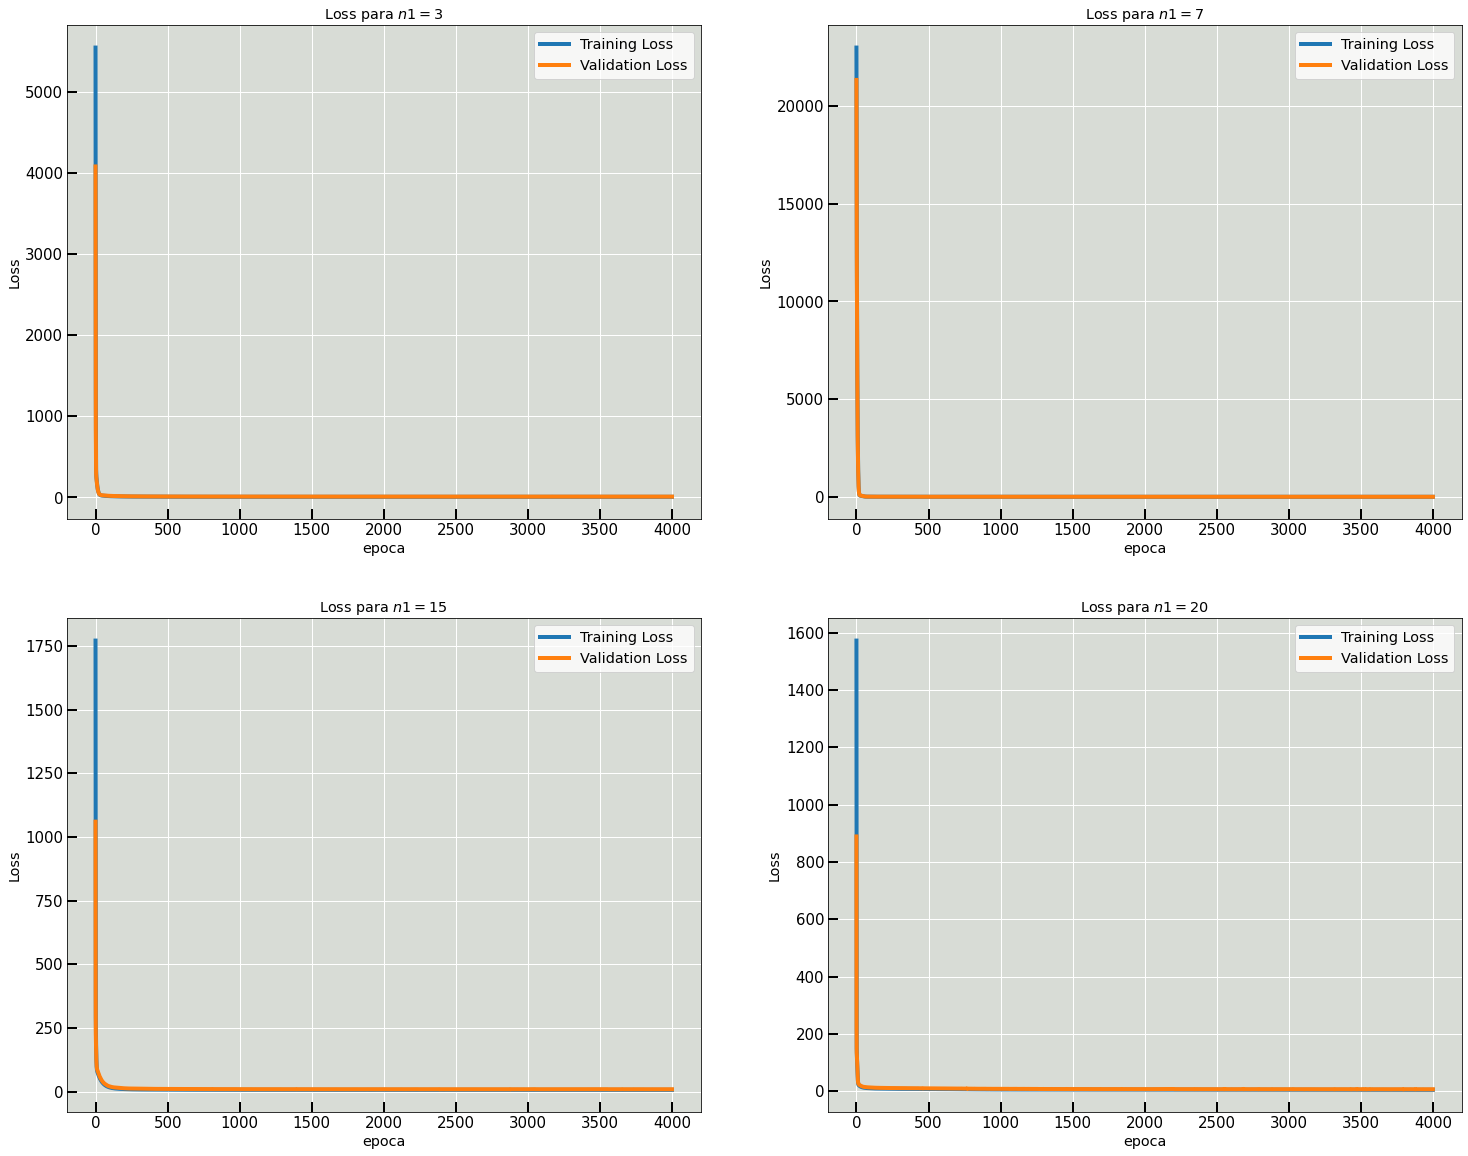

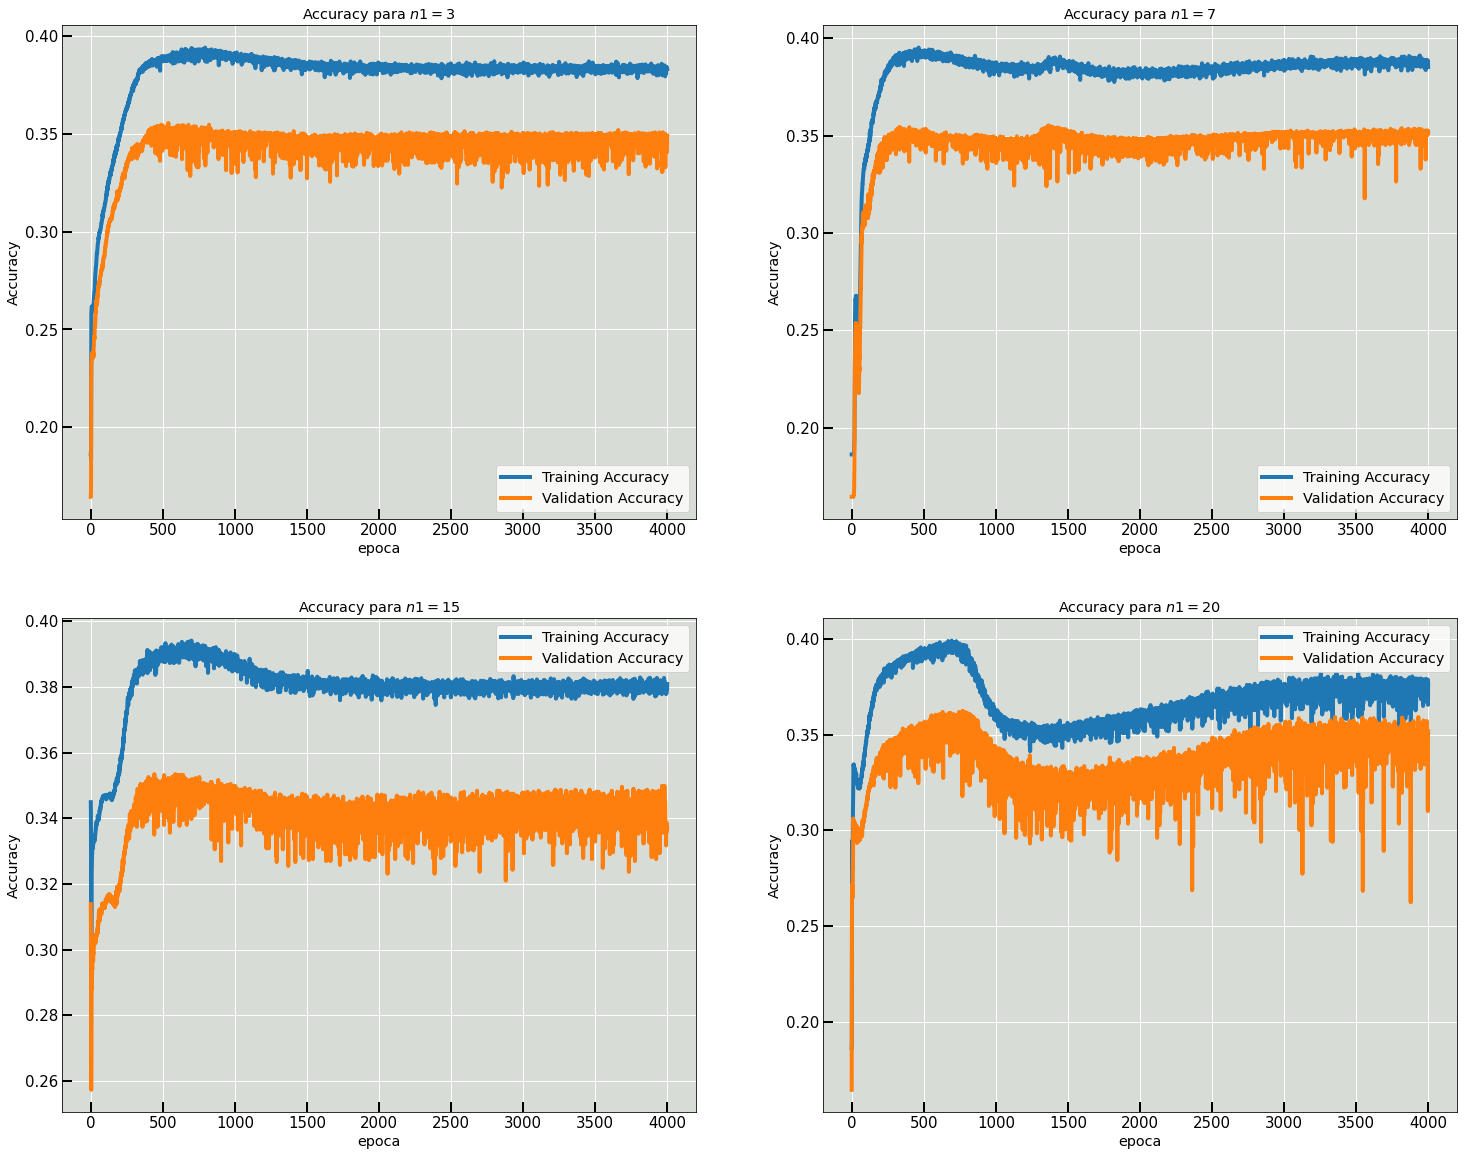

In [39]:
fig, ax = plt.subplots(2,2,figsize=(25,20))
format(ax)
for i,n in enumerate(ns):
    ax[i//2,i%2].set_ylabel('Loss',fontsize='x-large')
    ax[i//2,i%2].set_xlabel('epoca',fontsize='x-large')
    ax[i//2,i%2].plot(historys[i].history['loss'], label='Training Loss', linewidth=4)
    ax[i//2,i%2].plot(historys[i].history['val_loss'], label='Validation Loss', linewidth=4)
    ax[i//2,i%2].set_title(rf"Loss para $n1={n}$",fontsize='x-large')
    ax[i//2,i%2].legend(fontsize='x-large')

fig2, ax2 = plt.subplots(2,2,figsize=(25,20))
format(ax2)
for i,n in enumerate(ns):
    ax2[i//2,i%2].set_ylabel('Accuracy',fontsize='x-large')
    ax2[i//2,i%2].set_xlabel('epoca',fontsize='x-large')
    ax2[i//2,i%2].plot(historys[i].history['accuracy'], label='Training Accuracy', linewidth=4)
    ax2[i//2,i%2].plot(historys[i].history['val_accuracy'], label='Validation Accuracy', linewidth=4)
    ax2[i//2,i%2].set_title(rf"Accuracy para $n1={n}$",fontsize='x-large')
    ax2[i//2,i%2].legend(fontsize='x-large')

El loss sigue sin caer lo suficiente para todos los casos

### Dos capas ocultas

In [41]:
class dos_capas:
    def __init__(self, n1, n2):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(n2,activation='relu'))
        self.model.add(Dense(1,activation='linear'))
        self.model.compile
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000): 
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=100)])
        return history

De vuelta vamos a jugar un poco con los tamaños de las capas

In [42]:
ns = [3,7,15,20]

models=[]
historys=[]
for n1 in ns:
    for n2 in ns:
        print (f"n1={n1},n2={n2}")
        model = dos_capas(n1,n2)
        history = model.train(X_train, Y_train, X_test, Y_test, epochs=4000)
        models.append(model)
        historys.append(history)

n1=3,n2=3
Epoch 1: loss = 5035.052734375, val_loss = 4367.74365234375, acc=0.186153843998909, val_acc = 0.16438356041908264
Epoch 100: loss = 20.15321159362793, val_loss = 26.327512741088867, acc=0.3444615304470062, val_acc = 0.31268611550331116
Epoch 200: loss = 18.442319869995117, val_loss = 24.14464569091797, acc=0.34507691860198975, val_acc = 0.3141750991344452
Epoch 300: loss = 18.419780731201172, val_loss = 24.125, acc=0.3453846275806427, val_acc = 0.31447291374206543
Epoch 400: loss = 18.41366195678711, val_loss = 24.115522384643555, acc=0.3453846275806427, val_acc = 0.31447291374206543
Epoch 500: loss = 18.387887954711914, val_loss = 24.10344696044922, acc=0.3453846275806427, val_acc = 0.31447291374206543
Epoch 600: loss = 18.308744430541992, val_loss = 24.025300979614258, acc=0.3451538383960724, val_acc = 0.31447291374206543
Epoch 700: loss = 17.91560935974121, val_loss = 23.463396072387695, acc=0.3451538383960724, val_acc = 0.3147706985473633
Epoch 800: loss = 8.8925924301147

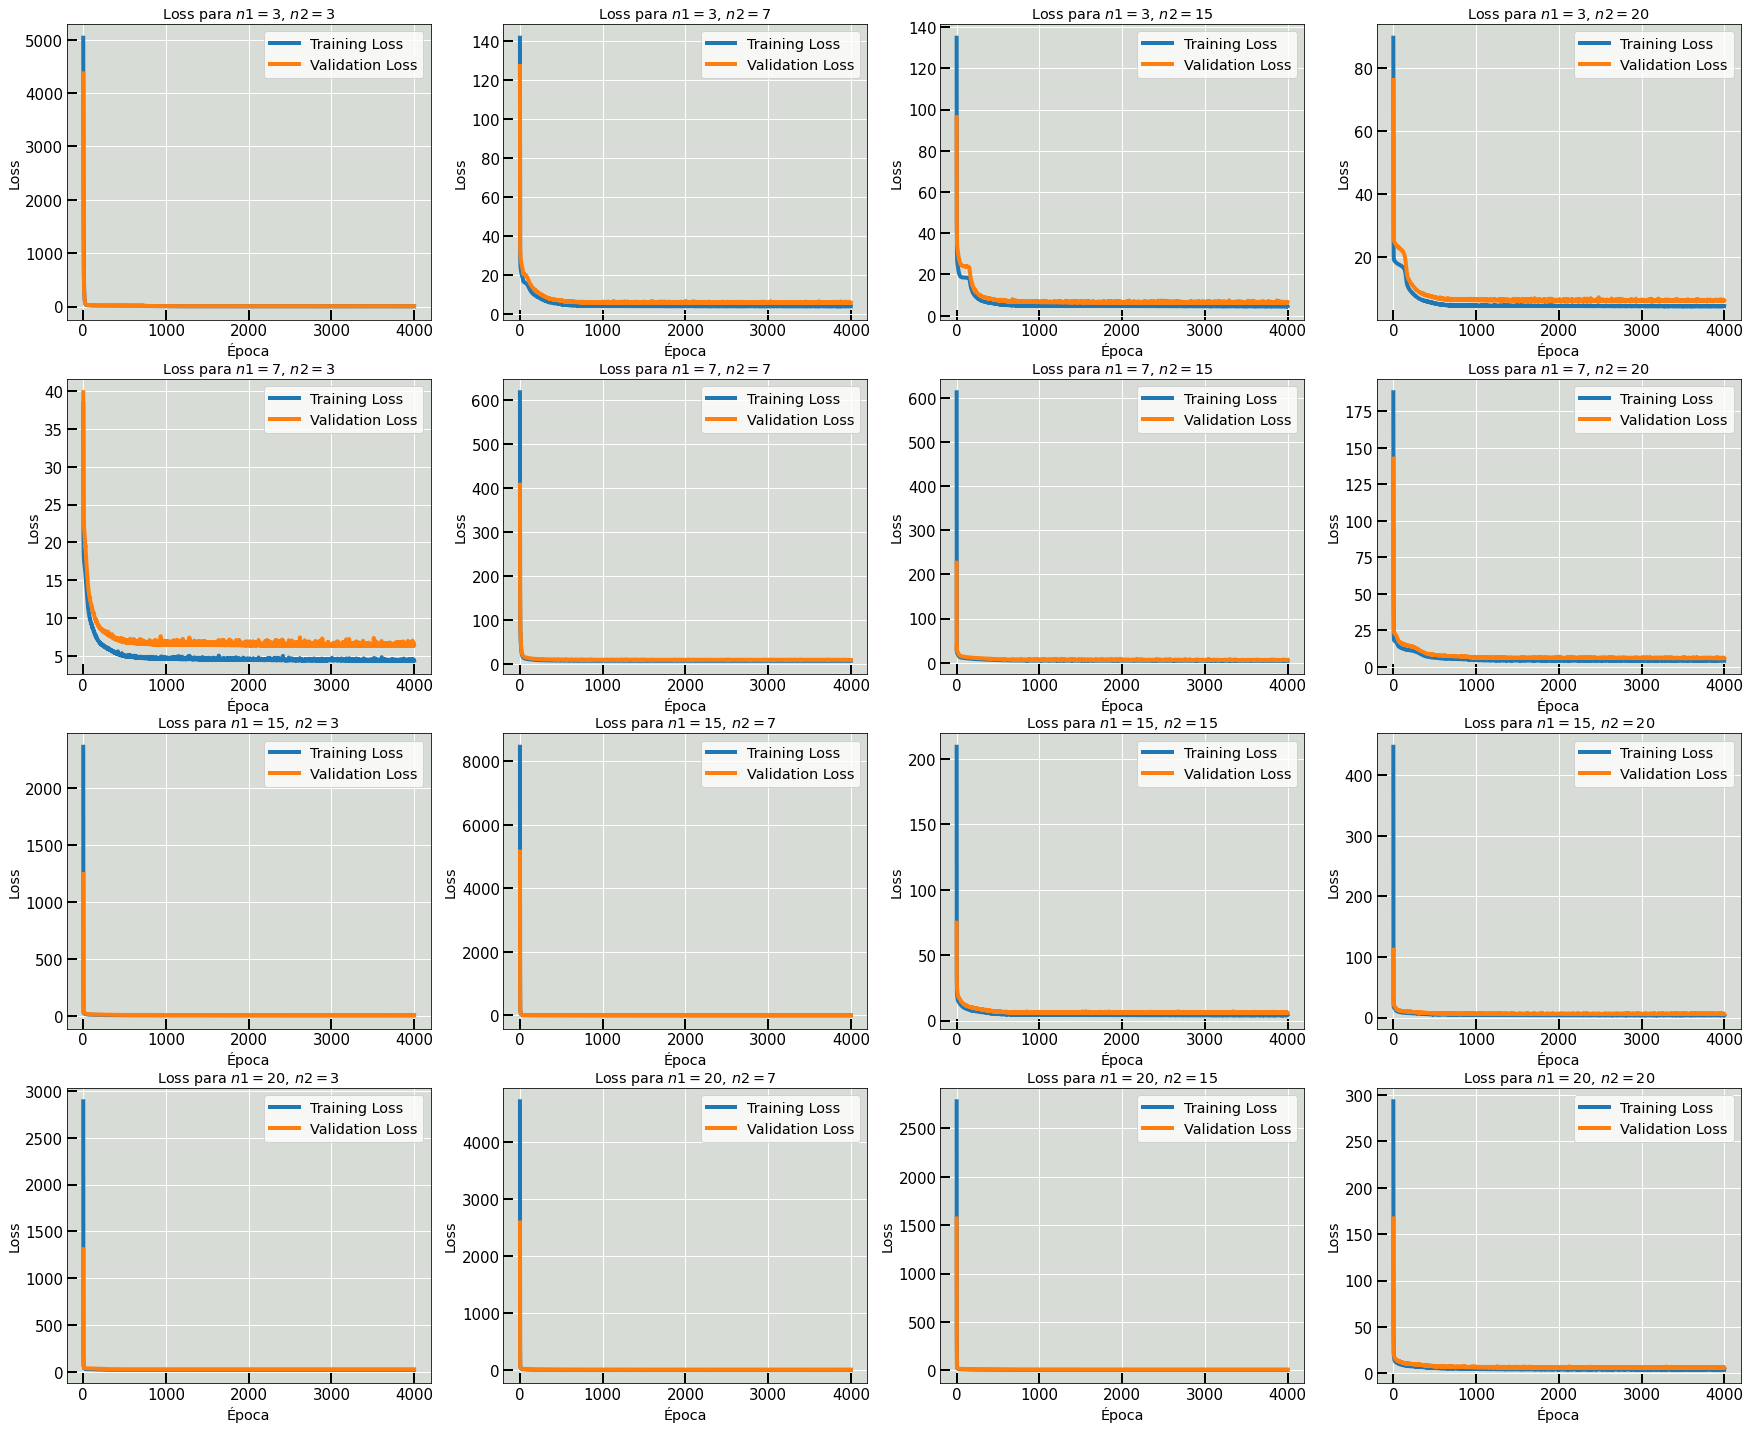

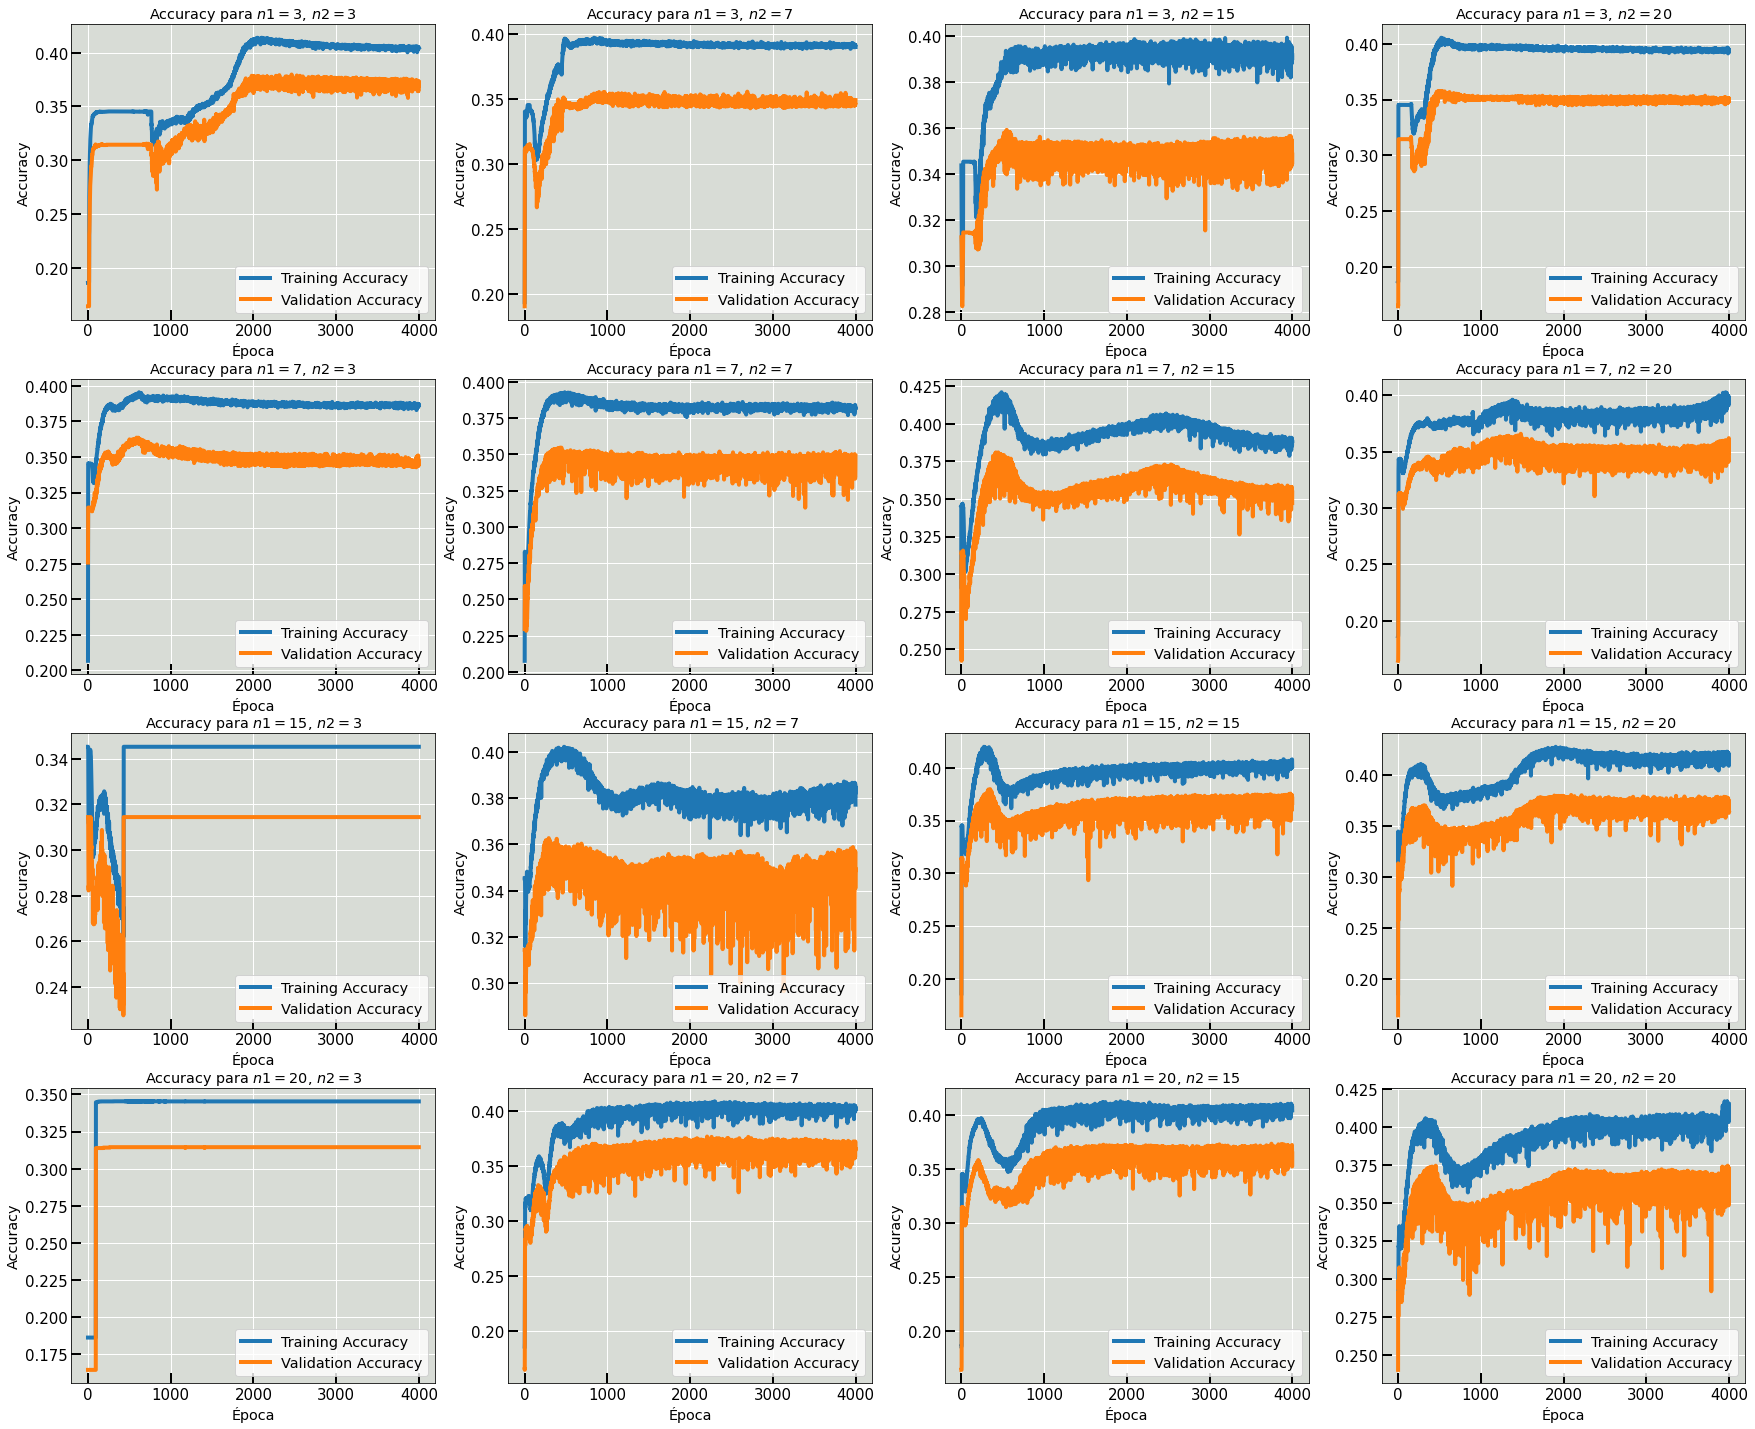

In [44]:
fig, ax = plt.subplots(4,4,figsize=(30,25))
format(ax)
for i,n1 in enumerate(ns):
    for j,n2 in enumerate(ns):
        ax[i,j].set_ylabel('Loss',fontsize='x-large')
        ax[i,j].set_xlabel('Época',fontsize='x-large')
        ax[i,j].plot(historys[(i*4)+j].history['loss'], label='Training Loss', linewidth=4)
        ax[i,j].plot(historys[(i*4)+j].history['val_loss'], label='Validation Loss', linewidth=4)
        ax[i,j].set_title(rf"Loss para $n1={n1}$, $n2={n2}$",fontsize='x-large')
        ax[i,j].legend(fontsize='x-large')

fig2, ax2 = plt.subplots(4,4,figsize=(30,25))
format(ax2)
for i,n1 in enumerate(ns):
    for j,n2 in enumerate(ns):
        ax2[i,j].set_ylabel('Accuracy',fontsize='x-large')
        ax2[i,j].set_xlabel('Época',fontsize='x-large')
        ax2[i,j].plot(historys[(i*4)+j].history['accuracy'], label='Training Accuracy', linewidth=4)
        ax2[i,j].plot(historys[(i*4)+j].history['val_accuracy'], label='Validation Accuracy', linewidth=4)
        ax2[i,j].set_title(rf"Accuracy para $n1={n1}$, $n2={n2}$",fontsize='x-large')
        ax2[i,j].legend(fontsize='x-large')

En todos los casos vemos que el accuracy es bajo y el loss es muy alto.

## Redes con output OH

### One hot encode the data


Vamos a probar algo distinto porque evidentemente el aproach que estoy tomando no está funcionando. En lugar de tener en salida el número del Score, vamos a dividirlo en 3 categorías:
- Sin riesgo si el score vale 0 o 1
- Riesgo moderado si el Score está entre [2,5]
- Riesgo alto si el Score es mayor a 5

In [12]:
Y_oh = np.ones_like(Y)
Y_oh[Y<2] = 0
Y_oh[Y>5] = 2

unique_values, counts = np.unique(Y_oh, return_counts=True)
for value, count in zip(unique_values, counts):
    print(f"Value {value} occurs {count} times")

Value 0 occurs 8517 times
Value 1 occurs 4879 times
Value 2 occurs 2962 times


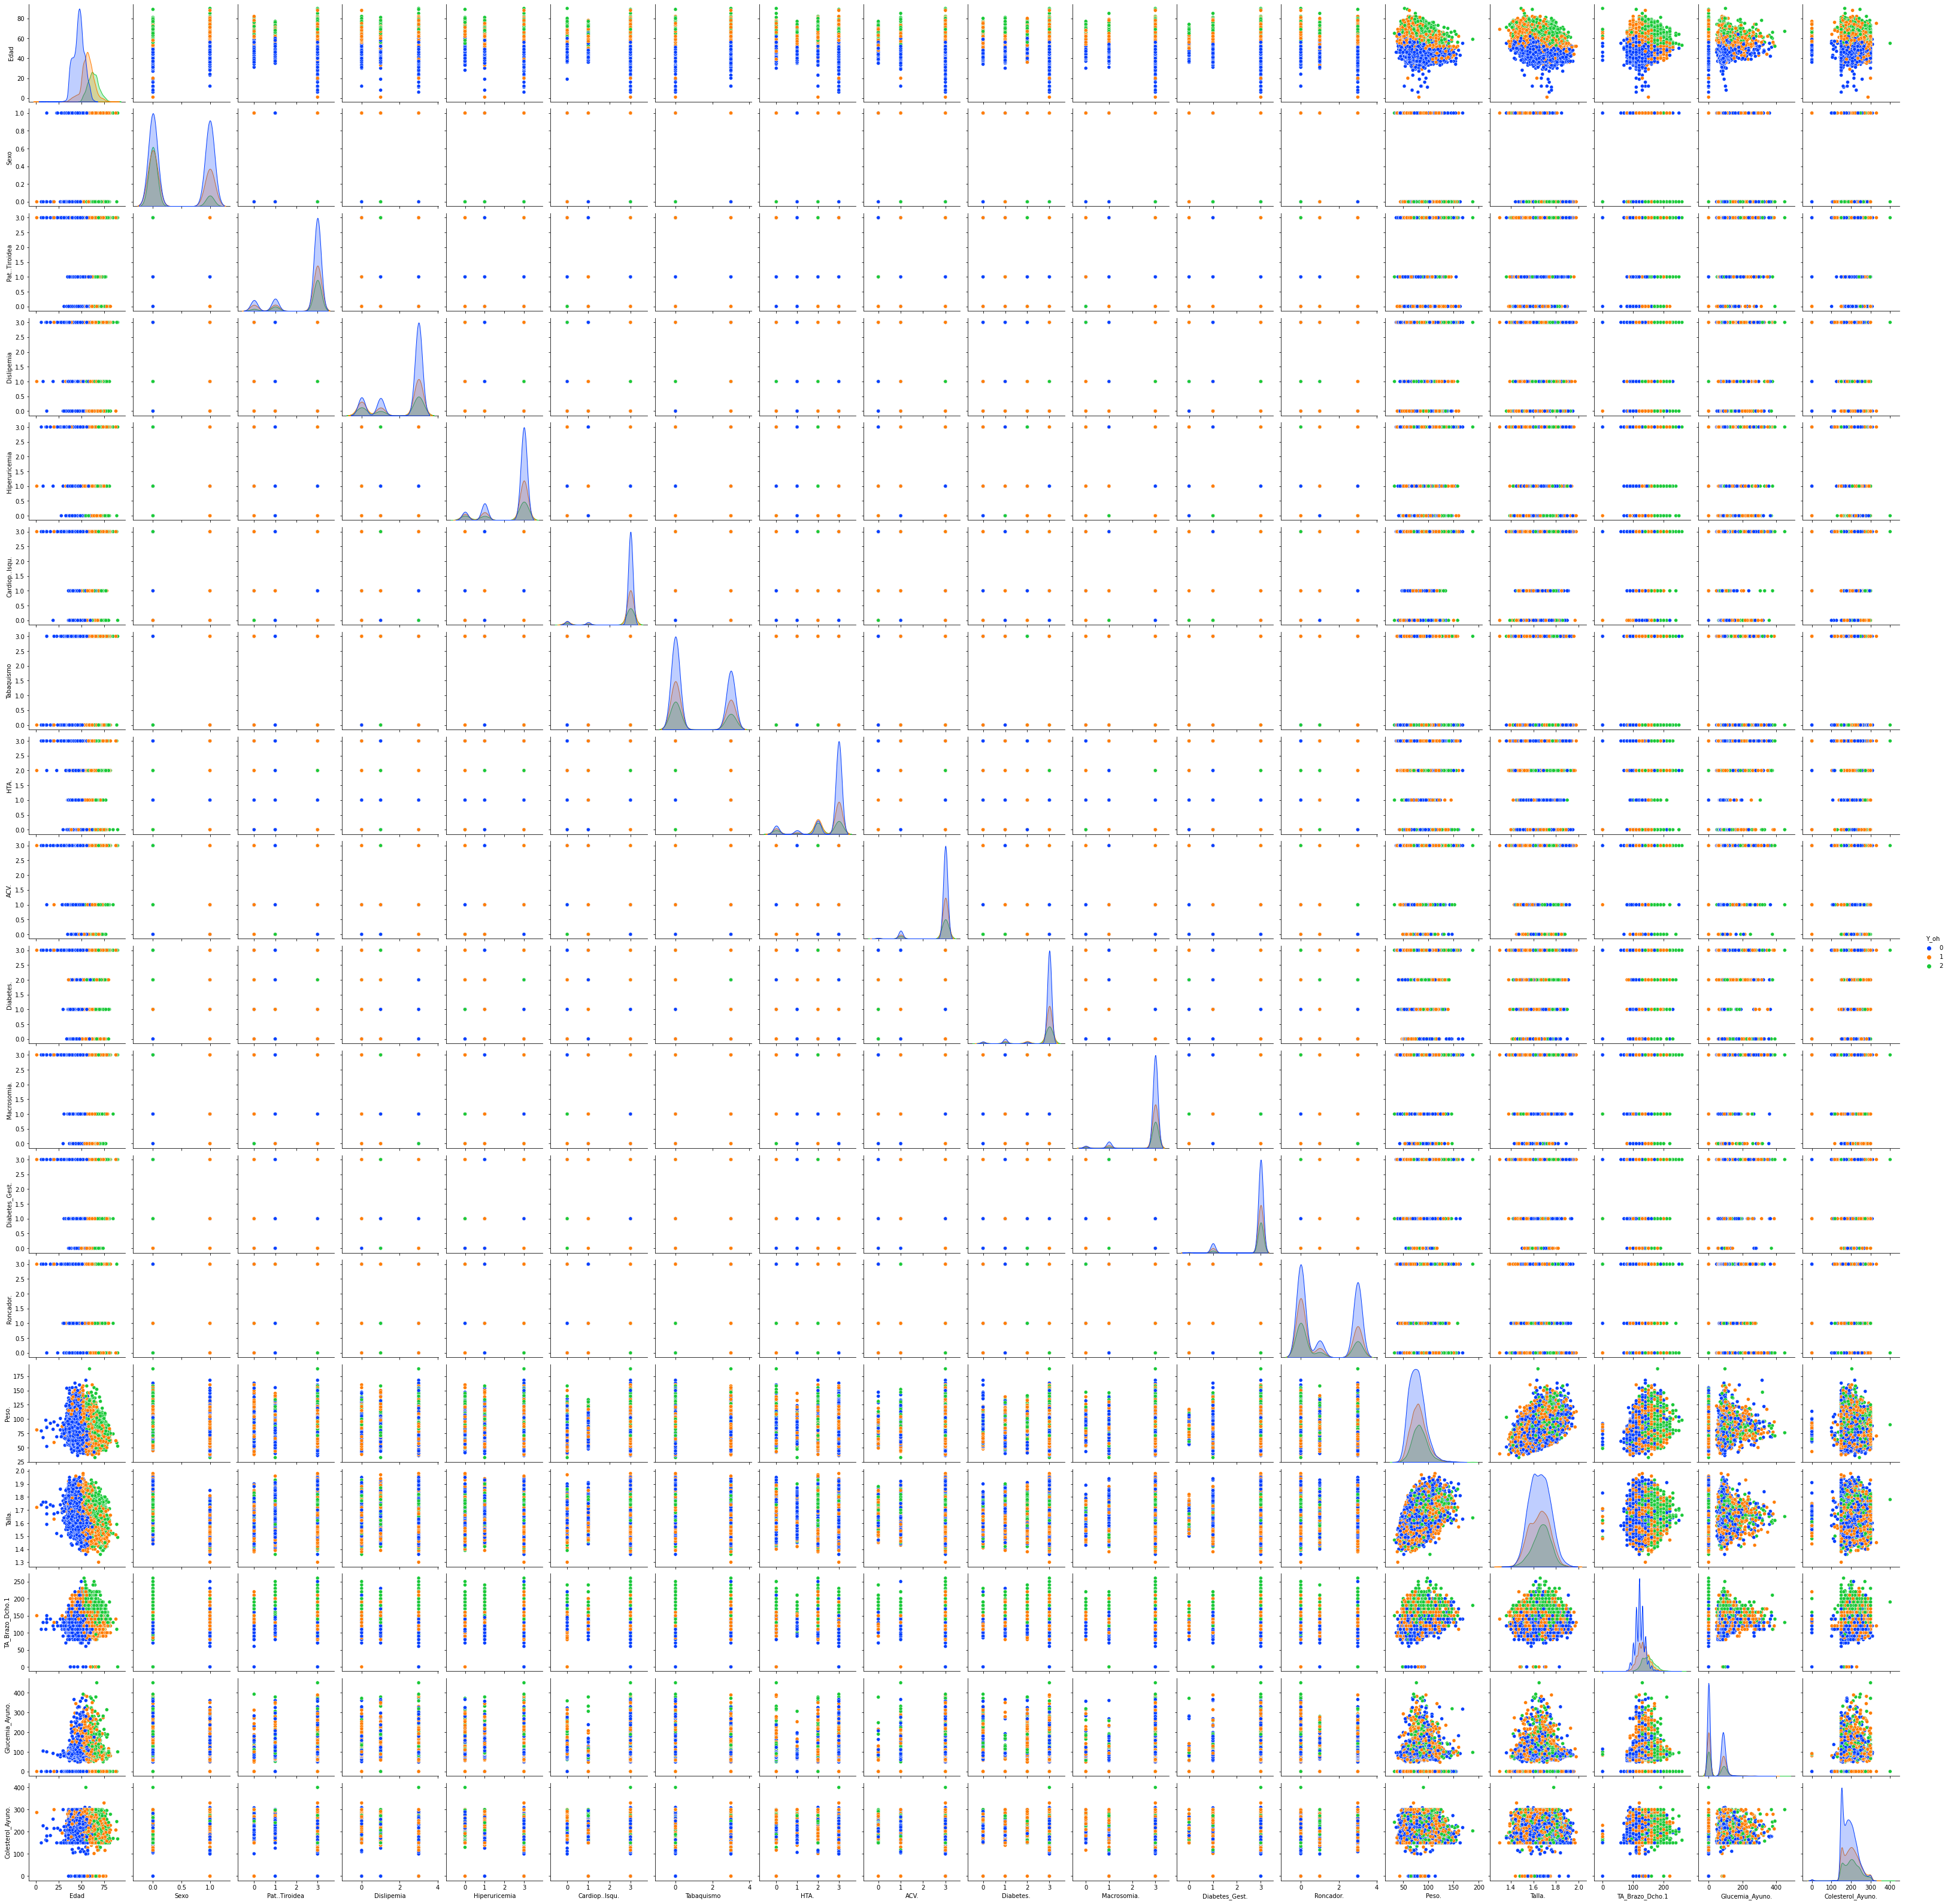

In [12]:
df=X.copy()
df['Y_oh']=Y_oh
sns.pairplot(df, hue='Y_oh', palette='bright')

No se ven características o combinación de ellas que permitan dividir los niveles haciendo algo como un tree.

In [13]:
Y_ohfinal = np.copy(Y_oh)
Y_oh = to_categorical(Y_oh)
Y_trainoh = Y_oh[:13000]
Y_testoh = Y_oh[13000:]

Vamos a hacer el mismo análisis que el caso de salida de una neurona.

### Sin capas ocultas OH

In [47]:
class sin_capaOH:
    def __init__(self):
        self.model = Sequential()
        self.model.add(Dense(18,input_dim=18,activation='relu'))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile(optimizer=optimizers.Adam(learning_rate=3e-4), loss='mse', metrics=['accuracy'])
    def train(self, X_train, Y_train, X_test, Y_test, epochs=100, batch_size=13000):
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0,callbacks=[PrintEveryN(n=500)])
        return history

In [48]:
percept = sin_capaOH()
history = percept.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=4000)


Epoch 1: loss = 0.31231844425201416, val_loss = 0.3481629490852356, acc=0.5293846130371094, val_acc = 0.4752829074859619
Epoch 500: loss = 0.1954759657382965, val_loss = 0.20716939866542816, acc=0.6397692561149597, val_acc = 0.6164383292198181
Epoch 1000: loss = 0.18493346869945526, val_loss = 0.19674572348594666, acc=0.6676154136657715, val_acc = 0.6459202170372009
Epoch 1500: loss = 0.17965121567249298, val_loss = 0.1915910392999649, acc=0.6803076863288879, val_acc = 0.653662919998169
Epoch 2000: loss = 0.1762615293264389, val_loss = 0.18836897611618042, acc=0.686846137046814, val_acc = 0.662894606590271
Epoch 2500: loss = 0.17403554916381836, val_loss = 0.18631906807422638, acc=0.6903846263885498, val_acc = 0.6664681434631348
Epoch 3000: loss = 0.17255577445030212, val_loss = 0.1849440187215805, acc=0.6936153769493103, val_acc = 0.6670637130737305
Epoch 3500: loss = 0.17143870890140533, val_loss = 0.18392309546470642, acc=0.6953846216201782, val_acc = 0.6688504815101624
Epoch 4000: 

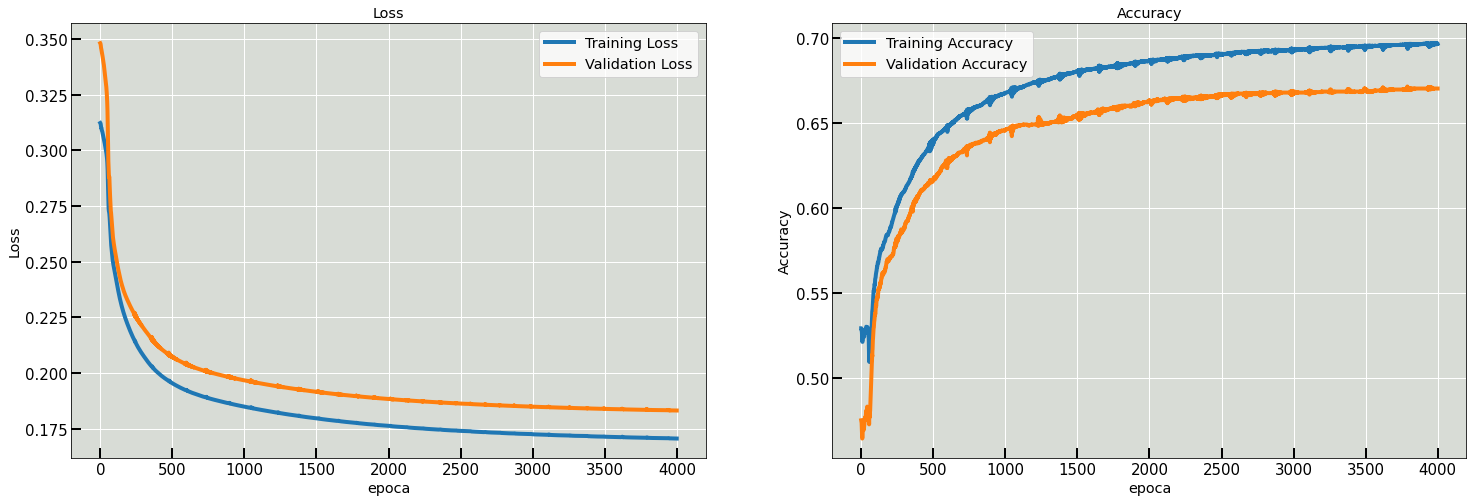

In [49]:
fig, ax = plt.subplots(1,2,figsize=(25,8))
format(ax)
ax[0].set_ylabel('Loss',fontsize='x-large')
ax[0].set_xlabel('epoca',fontsize='x-large')
ax[0].plot(history.history['loss'], label='Training Loss', linewidth=4)
ax[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=4)
ax[0].set_title(r"Loss",fontsize='x-large')
ax[0].legend(fontsize='x-large')

ax[1].set_ylabel('Accuracy',fontsize='x-large')
ax[1].set_xlabel('epoca',fontsize='x-large')
ax[1].plot(history.history['accuracy'], label='Training Accuracy',linewidth=4)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy',linewidth=4)
ax[1].set_title(r"Accuracy",fontsize='x-large')
ax[1].legend(fontsize='x-large')

Vemos como claramente bajó el loss. Esto es bueno, vamos a analizar capas y tamaños.

### Una capa oculta OH

In [50]:
class una_capaOH:
    def __init__(self, n1):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=13000): 
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=500)])
        return history

Vamos a utilizar varias cantidades de neuronas en esta única capa para ver cual es la mejor opción.

In [51]:
ns = [3,7,15,20]
models=[]
historys=[]
for n1 in ns:
    print (f"n={n1}")
    model = una_capaOH(n1)
    history = model.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=4000)
    models.append(model)
    historys.append(history)

n=3
Epoch 1: loss = 0.31155672669410706, val_loss = 0.3470134139060974, acc=0.5307692289352417, val_acc = 0.4770696759223938
Epoch 500: loss = 0.19857904314994812, val_loss = 0.2156614363193512, acc=0.5892307758331299, val_acc = 0.5431804656982422
Epoch 1000: loss = 0.18631449341773987, val_loss = 0.20332564413547516, acc=0.6242307424545288, val_acc = 0.5929124355316162
Epoch 1500: loss = 0.17199178040027618, val_loss = 0.1890241950750351, acc=0.6836923360824585, val_acc = 0.6512805223464966
Epoch 2000: loss = 0.1686021387577057, val_loss = 0.18663224577903748, acc=0.7016922831535339, val_acc = 0.6620011925697327
Epoch 2500: loss = 0.16675087809562683, val_loss = 0.18545721471309662, acc=0.7123076915740967, val_acc = 0.6730196475982666
Epoch 3000: loss = 0.16565246880054474, val_loss = 0.18465739488601685, acc=0.7167692184448242, val_acc = 0.6795711517333984
Epoch 3500: loss = 0.1648063063621521, val_loss = 0.18402035534381866, acc=0.7203845977783203, val_acc = 0.6837403178215027
Epoch

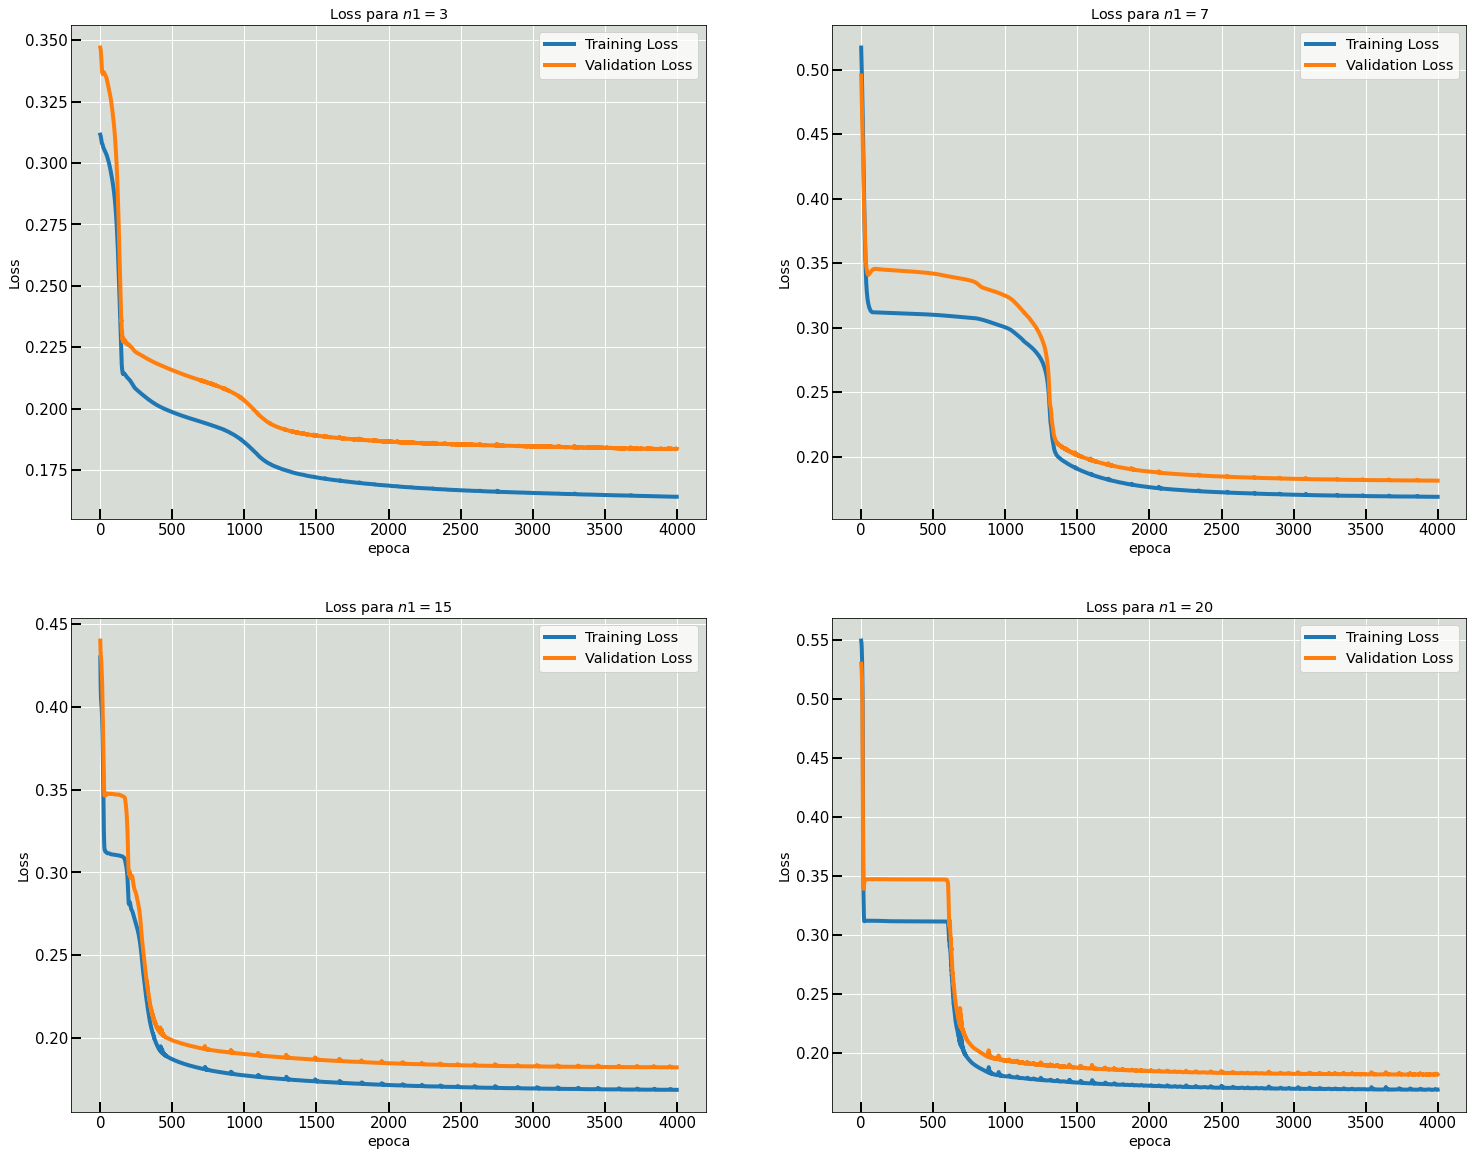

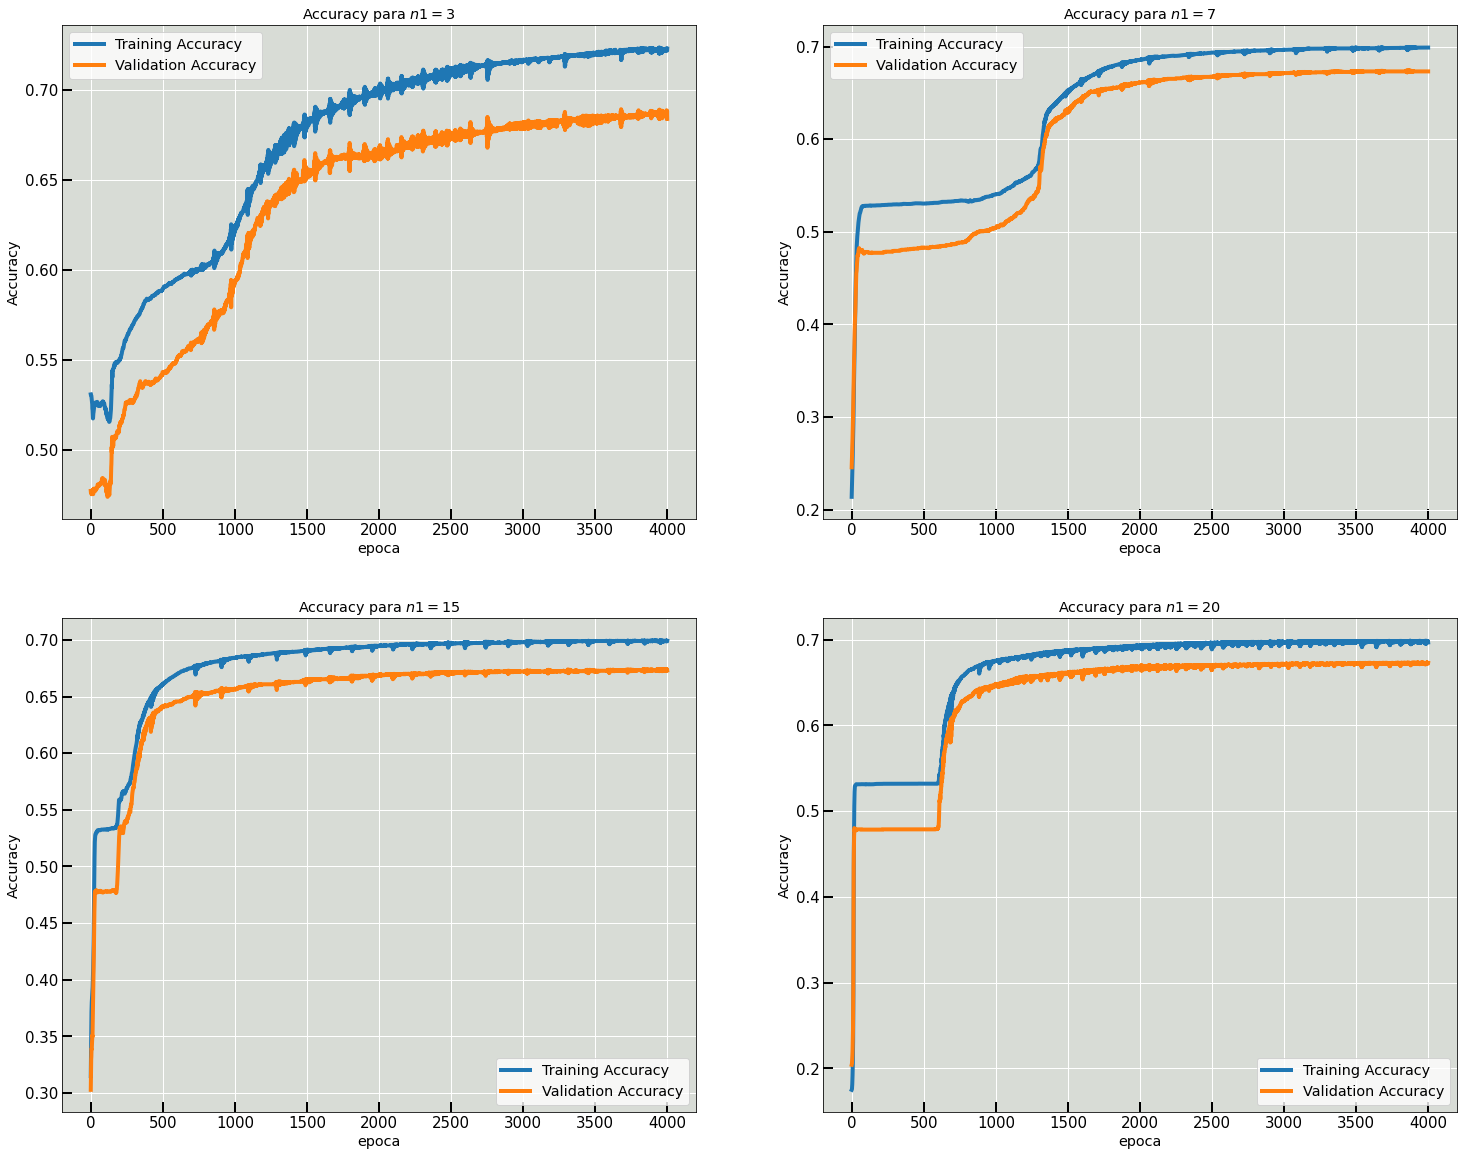

In [52]:
fig, ax = plt.subplots(2,2,figsize=(25,20))
format(ax)
for i,n in enumerate(ns):
    ax[i//2,i%2].set_ylabel('Loss',fontsize='x-large')
    ax[i//2,i%2].set_xlabel('epoca',fontsize='x-large')
    ax[i//2,i%2].plot(historys[i].history['loss'], label='Training Loss', linewidth=4)
    ax[i//2,i%2].plot(historys[i].history['val_loss'], label='Validation Loss', linewidth=4)
    ax[i//2,i%2].set_title(rf"Loss para $n1={n}$",fontsize='x-large')
    ax[i//2,i%2].legend(fontsize='x-large')

fig2, ax2 = plt.subplots(2,2,figsize=(25,20))
format(ax2)
for i,n in enumerate(ns):
    ax2[i//2,i%2].set_ylabel('Accuracy',fontsize='x-large')
    ax2[i//2,i%2].set_xlabel('epoca',fontsize='x-large')
    ax2[i//2,i%2].plot(historys[i].history['accuracy'], label='Training Accuracy', linewidth=4)
    ax2[i//2,i%2].plot(historys[i].history['val_accuracy'], label='Validation Accuracy', linewidth=4)
    ax2[i//2,i%2].set_title(rf"Accuracy para $n1={n}$",fontsize='x-large')
    ax2[i//2,i%2].legend(fontsize='x-large')

### Dos capas ocultas OH

In [13]:
class dos_capasOH:
    def __init__(self, n1, n2):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(n2,activation='relu'))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000): 
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=1000)])
        return history

De vuelta vamos a jugar un poco con los tamaños de las capas

In [54]:
ns = [3,7,15,20]

models=[]
historys=[]
for n1 in ns:
    for n2 in ns:
        print (f"n1={n1},n2={n2}")
        model = dos_capasOH(n1,n2)
        history = model.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=10000)
        models.append(model)
        historys.append(history)

n1=3,n2=3
Epoch 1: loss = 0.22195403277873993, val_loss = 0.22134290635585785, acc=0.5316153764724731, val_acc = 0.48004764318466187
Epoch 1000: loss = 0.08119448274374008, val_loss = 0.08381934463977814, acc=0.8283846378326416, val_acc = 0.8192376494407654
Epoch 2000: loss = 0.08051200956106186, val_loss = 0.0824272632598877, acc=0.829153835773468, val_acc = 0.8207266330718994
Epoch 3000: loss = 0.0801558569073677, val_loss = 0.08205236494541168, acc=0.8309230804443359, val_acc = 0.8257891535758972
Epoch 4000: loss = 0.07975807785987854, val_loss = 0.08134724944829941, acc=0.8307692408561707, val_acc = 0.8248957991600037
Epoch 5000: loss = 0.07951931655406952, val_loss = 0.08154556155204773, acc=0.8326153755187988, val_acc = 0.8275759220123291
Epoch 6000: loss = 0.07964827120304108, val_loss = 0.08120628446340561, acc=0.8327692151069641, val_acc = 0.8272781372070312
Epoch 7000: loss = 0.07948656380176544, val_loss = 0.08165929466485977, acc=0.8332307934761047, val_acc = 0.825789153575

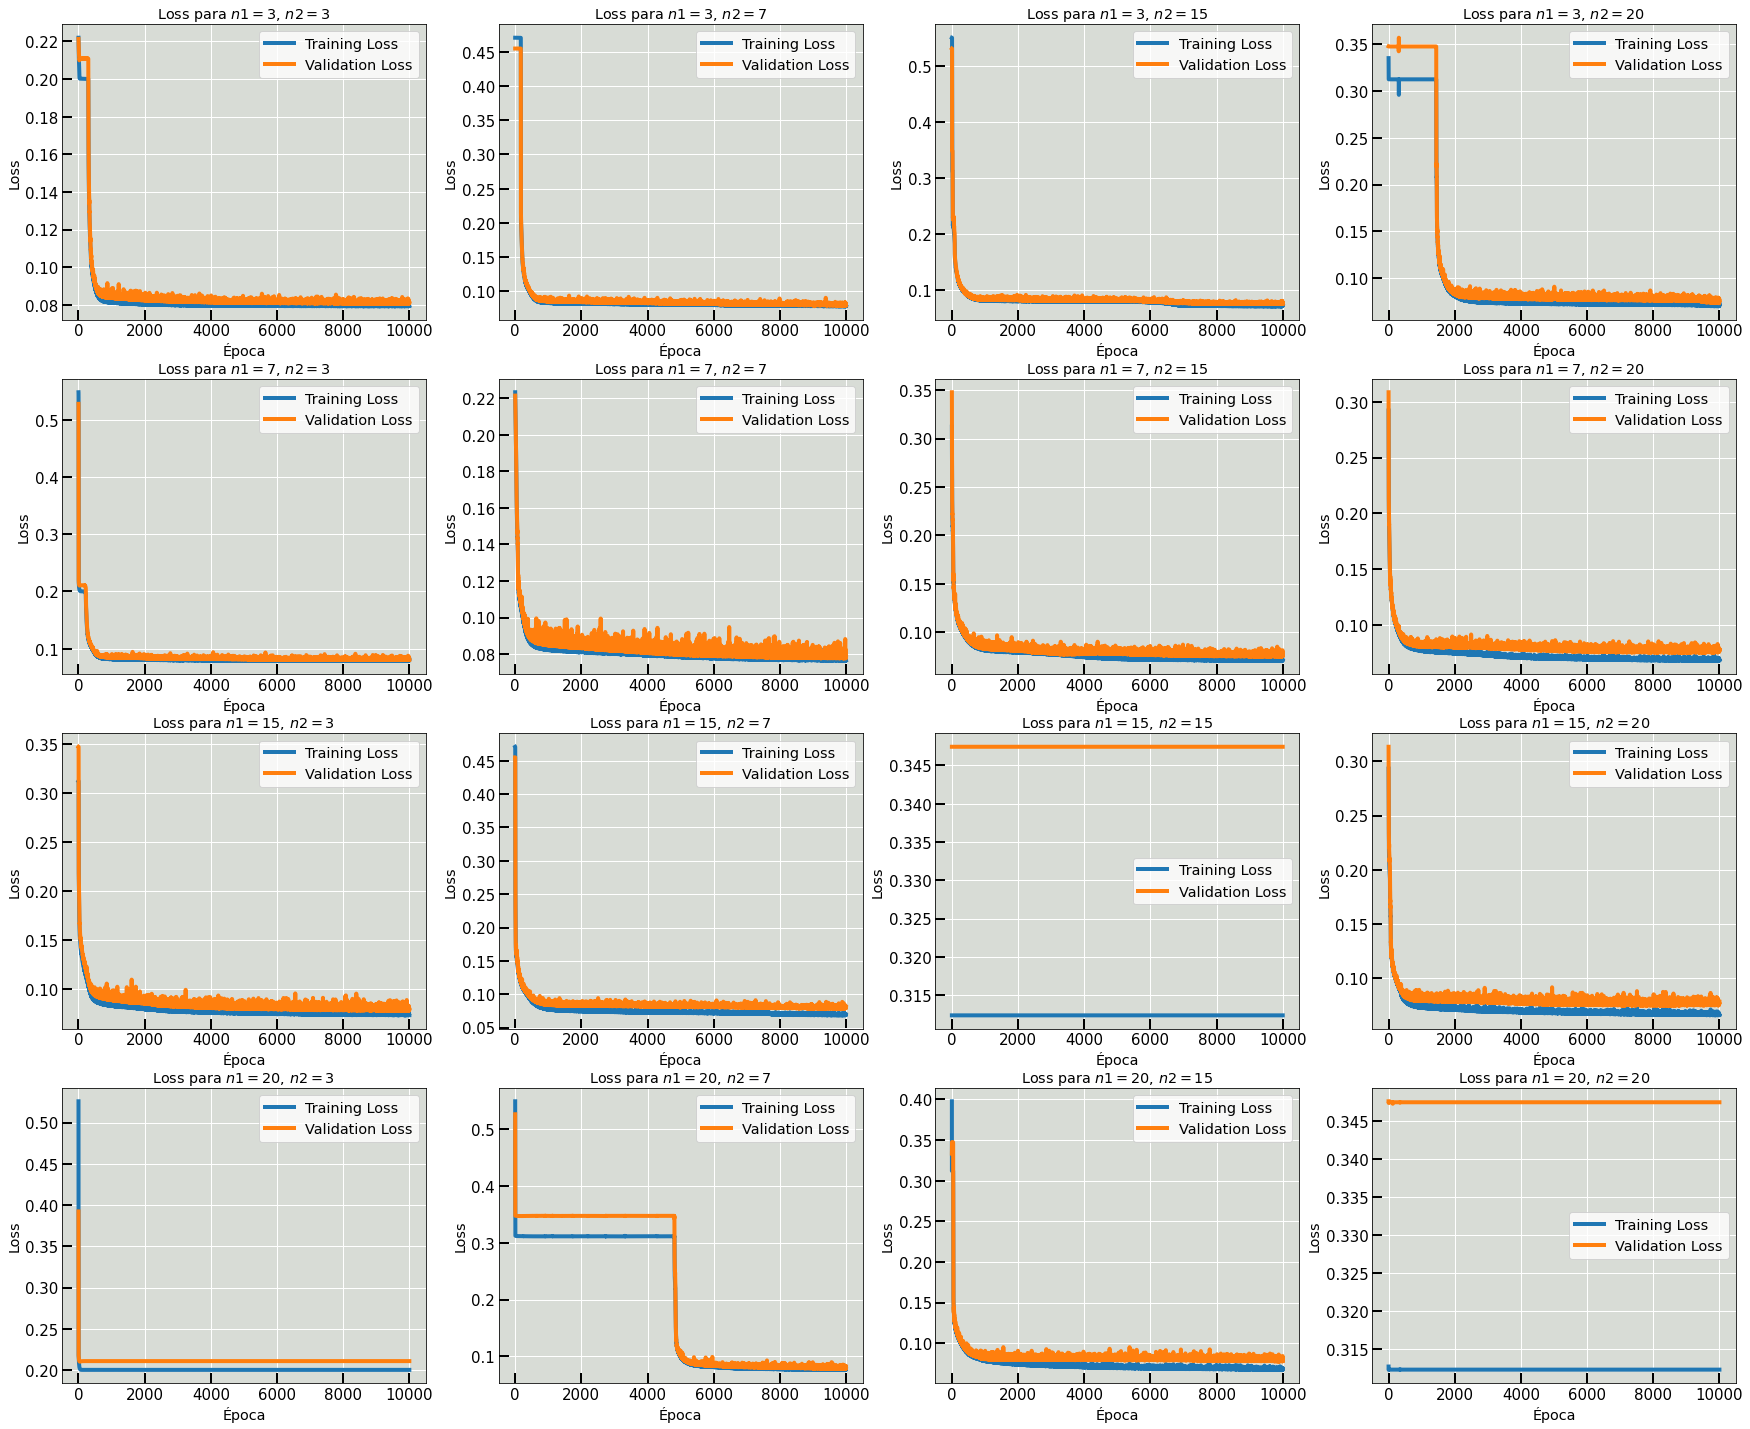

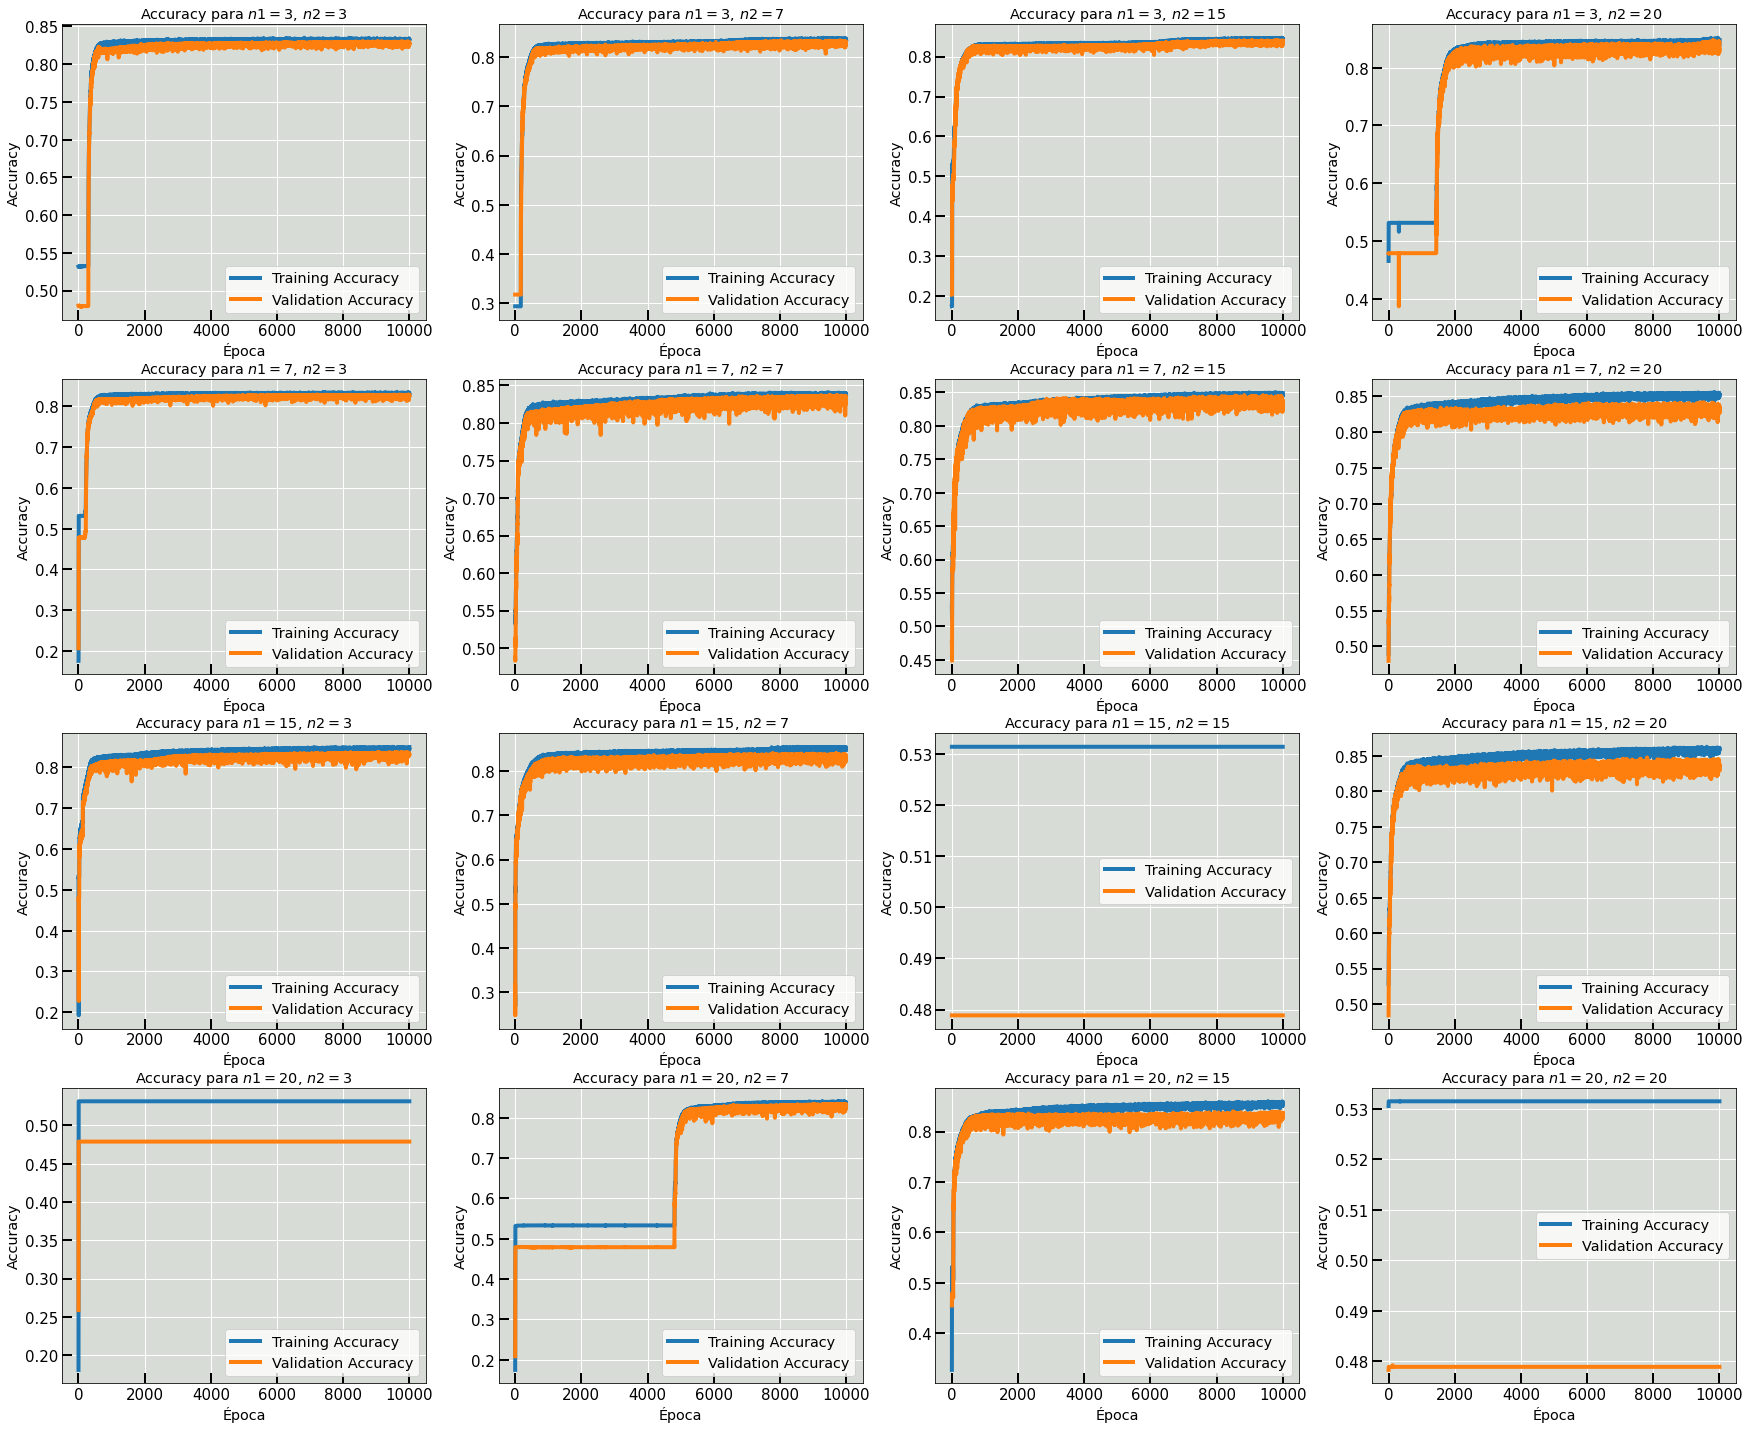

In [56]:
fig, ax = plt.subplots(4,4,figsize=(30,25))
format(ax)
for i,n1 in enumerate(ns):
    for j,n2 in enumerate(ns):
        ax[i,j].set_ylabel('Loss',fontsize='x-large')
        ax[i,j].set_xlabel('Época',fontsize='x-large')
        ax[i,j].plot(historys[(i*4)+j].history['loss'], label='Training Loss', linewidth=4)
        ax[i,j].plot(historys[(i*4)+j].history['val_loss'], label='Validation Loss', linewidth=4)
        ax[i,j].set_title(rf"Loss para $n1={n1}$, $n2={n2}$",fontsize='x-large')
        ax[i,j].legend(fontsize='x-large')

fig2, ax2 = plt.subplots(4,4,figsize=(30,25))
format(ax2)
for i,n1 in enumerate(ns):
    for j,n2 in enumerate(ns):
        ax2[i,j].set_ylabel('Accuracy',fontsize='x-large')
        ax2[i,j].set_xlabel('Época',fontsize='x-large')
        ax2[i,j].plot(historys[(i*4)+j].history['accuracy'], label='Training Accuracy', linewidth=4)
        ax2[i,j].plot(historys[(i*4)+j].history['val_accuracy'], label='Validation Accuracy', linewidth=4)
        ax2[i,j].set_title(rf"Accuracy para $n1={n1}$, $n2={n2}$",fontsize='x-large')
        ax2[i,j].legend(fontsize='x-large')

## Conclusiones de las distintas redes

De todo el análisis y los resultados que vimos antes podemos deducir:
- Es claro que funcionan mucho mejor las redes con outputs donde categorizamos los niveles de gravedad de los pacientes.
- Los mejores resultados los tuvimos con dos capas ocultas.

Para concluir el trabajo, vamos a hacer un mejor análisis de cuando hay overfiting, dejando correr por mas epochs. Además vamos a hacer un ensemble de redes ya que supuestamente mejora por lo menos un 2% el accuracy. Vamos a usar una red de con dos capas ocultas con 7 y 15 neuronas y output categórico. Tambien vemos que cada tanto sucede un problema en el cual el sistema no evoluciona y no cambia los parámetros, supongo que por que se encuentra en un mínimo local. Deje un par de ejemplos de gusto así se puede observar esto. Me sucedió con todos los tamaños de redes y cantidad de neuronas y parece medio aleatorio. También probé usar distintos valores de learning rate fijos, y trate de usar learning rates adaptables pero nada funcionó. También probé usar otros tipos de optimizers pero tampoco. Si algo hicieron fue empeorarlo, por lo que volví al learning rate default de Adam en keras.

## Un par de pruebas más

### Batch Sizes

Vamos a probar modificando los batch sizes así de paso elegimos el mejor.

In [57]:
bs = [13000,6500,3250,2600,1625,1300,1000,650,520]
models=[]
historys=[]
for b in bs:
    print (f"Batch Size = {b}")
    model = dos_capasOH(7,15)
    history = model.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=1000,batch_size=b)
    models.append(model)
    historys.append(history)

Batch Size = 13000
Epoch 1: loss = 0.4711087644100189, val_loss = 0.45467591285705566, acc=0.29238462448120117, val_acc = 0.31655746698379517
Epoch 1000: loss = 0.10692165046930313, val_loss = 0.10999830812215805, acc=0.7794615626335144, val_acc = 0.7668254971504211
Batch Size = 6500
Epoch 1: loss = 0.5024946928024292, val_loss = 0.4677591919898987, acc=0.23715384304523468, val_acc = 0.25610482692718506
Epoch 1000: loss = 0.3360042870044708, val_loss = 0.31652140617370605, acc=0.34569230675697327, val_acc = 0.39398452639579773
Batch Size = 3250
Epoch 1: loss = 0.3291158676147461, val_loss = 0.328451544046402, acc=0.43946152925491333, val_acc = 0.4726027250289917
Epoch 1000: loss = 0.09020780026912689, val_loss = 0.0913849025964737, acc=0.8154615163803101, val_acc = 0.8088147640228271
Batch Size = 2600
Epoch 1: loss = 0.5488348603248596, val_loss = 0.5291007161140442, acc=0.1762307733297348, val_acc = 0.20518165826797485
Epoch 1000: loss = 0.1687391698360443, val_loss = 0.18153616786003

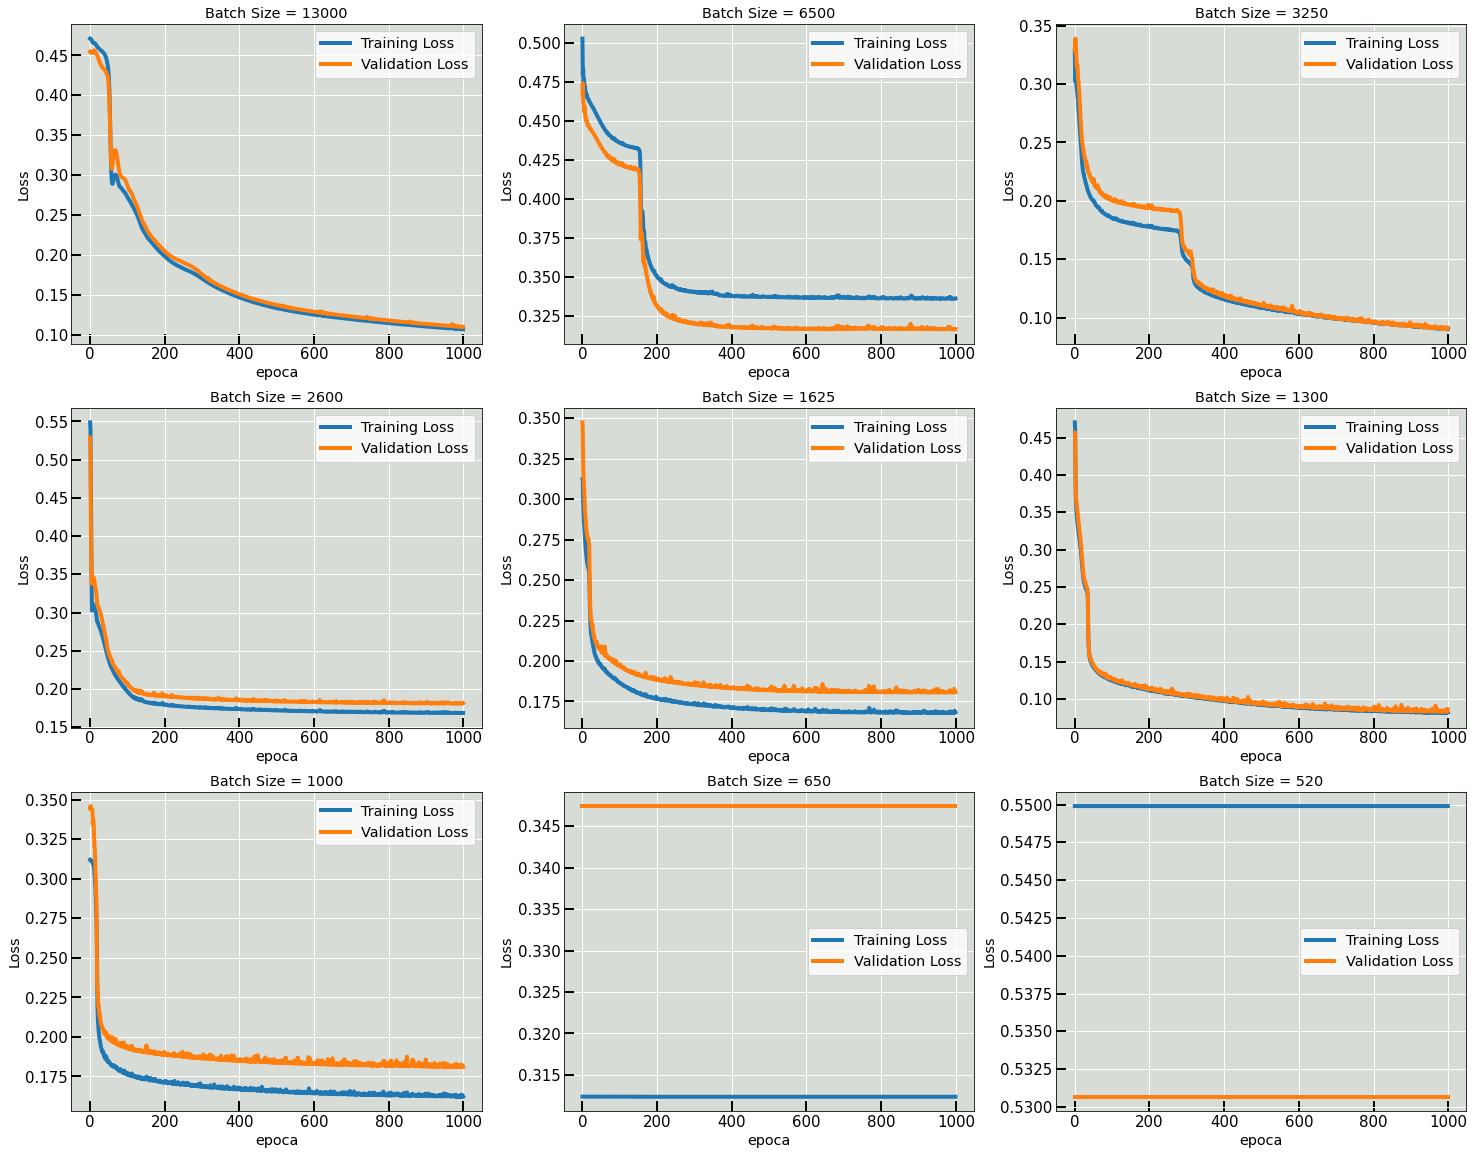

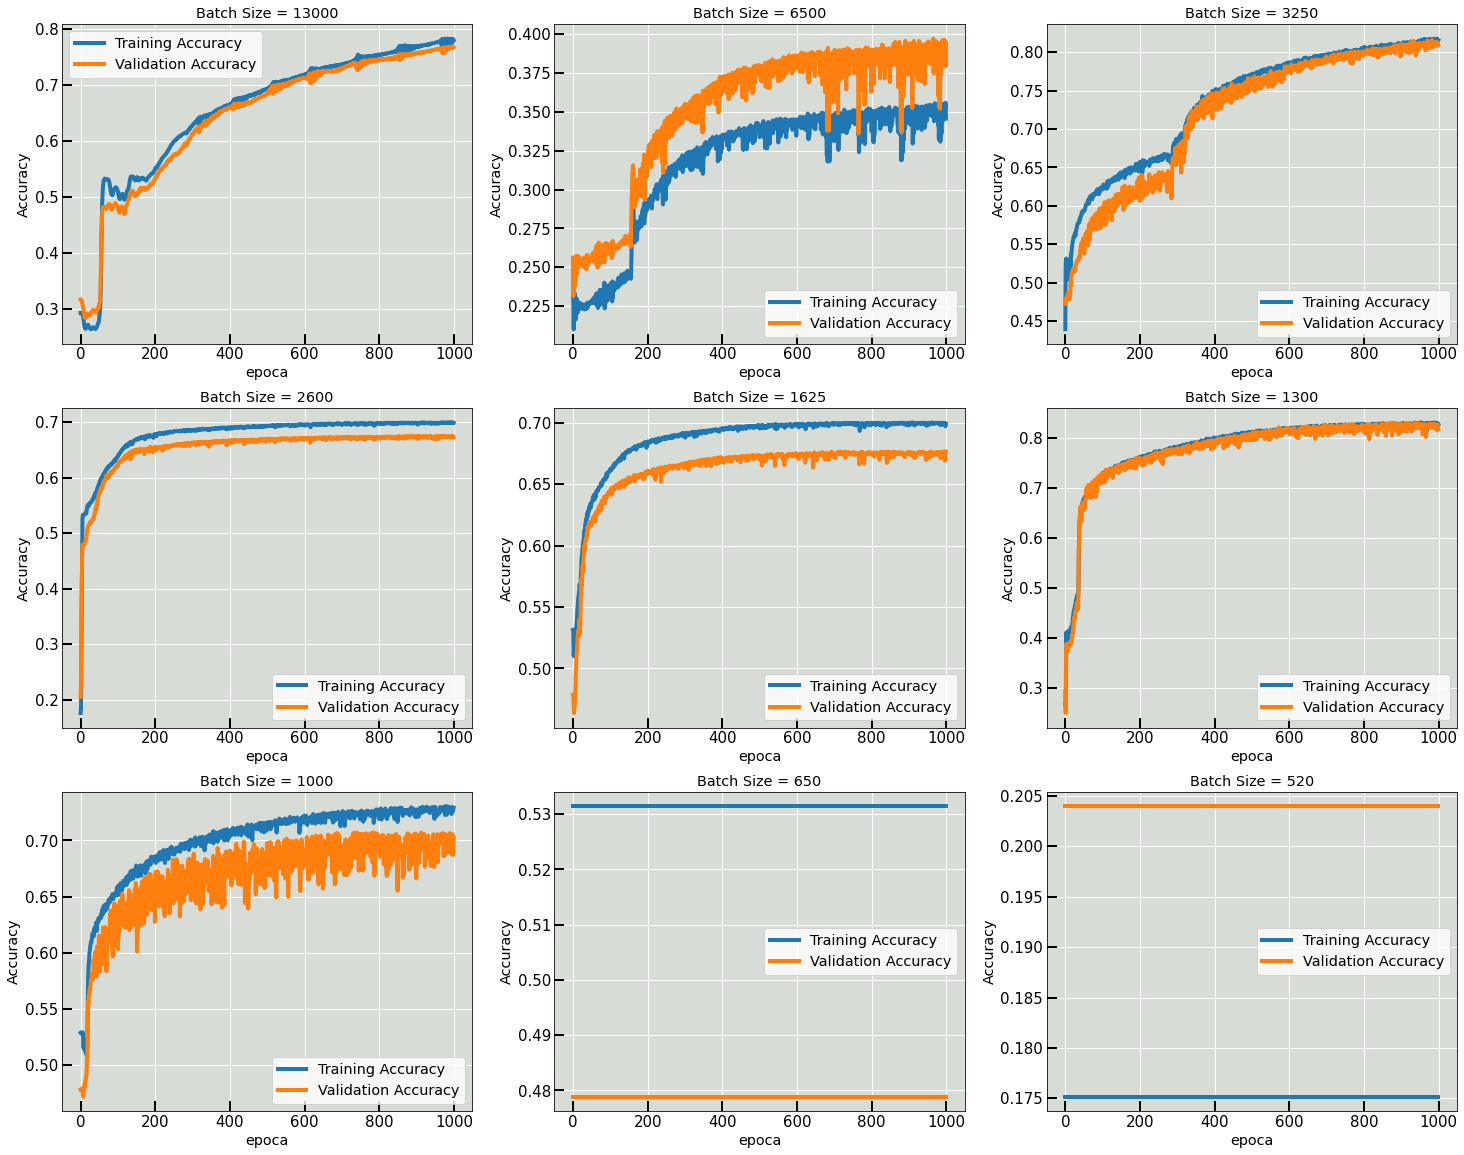

In [58]:
fig, ax = plt.subplots(3,3,figsize=(25,20))
format(ax)
for i,b in enumerate(bs):
    ax[i//3,i%3].set_ylabel('Loss',fontsize='x-large')
    ax[i//3,i%3].set_xlabel('epoca',fontsize='x-large')
    ax[i//3,i%3].plot(historys[i].history['loss'], label='Training Loss', linewidth=4)
    ax[i//3,i%3].plot(historys[i].history['val_loss'], label='Validation Loss', linewidth=4)
    ax[i//3,i%3].set_title(rf"Batch Size = {b}",fontsize='x-large')
    ax[i//3,i%3].legend(fontsize='x-large')

fig2, ax2 = plt.subplots(3,3,figsize=(25,20))
format(ax2)
for i,b in enumerate(bs):
    ax2[i//3,i%3].set_ylabel('Accuracy',fontsize='x-large')
    ax2[i//3,i%3].set_xlabel('epoca',fontsize='x-large')
    ax2[i//3,i%3].plot(historys[i].history['accuracy'], label='Training Accuracy', linewidth=4)
    ax2[i//3,i%3].plot(historys[i].history['val_accuracy'], label='Validation Accuracy', linewidth=4)
    ax2[i//3,i%3].set_title(rf"Batch Size = {b}",fontsize='x-large')
    ax2[i//3,i%3].legend(fontsize='x-large')

Tampoco soluciona el problema de los minimos locales, pero un batch size de 1000 parece adecuado ya que sale mas rapido del primer mínimo local que se encuentra, cuando lo hace. Aca quedó una iteración nomas pero las hice varias veces y pasa para todos los casos esto de que nos quedamos en un mínimo local.

### Prueba mas larga

Vamos a hacer ahora un entrenamiento largo para ver cuanto es el tiempo hasta llegar al overfitting.

Epoch 1: loss = 0.3434922993183136, val_loss = 0.34697210788726807, acc=0.44676923751831055, val_acc = 0.47885647416114807
Epoch 1000: loss = 0.08140242099761963, val_loss = 0.08367664366960526, acc=0.8283846378326416, val_acc = 0.816855251789093
Epoch 2000: loss = 0.07987284660339355, val_loss = 0.08201280981302261, acc=0.8304615616798401, val_acc = 0.8213222026824951
Epoch 3000: loss = 0.07998383790254593, val_loss = 0.08271989226341248, acc=0.8293846249580383, val_acc = 0.8237046003341675
Epoch 4000: loss = 0.07294720411300659, val_loss = 0.07741015404462814, acc=0.8429999947547913, val_acc = 0.8320428729057312
Epoch 5000: loss = 0.07298874855041504, val_loss = 0.0809045135974884, acc=0.8423846364021301, val_acc = 0.8210244178771973
Epoch 6000: loss = 0.07141665369272232, val_loss = 0.07662186771631241, acc=0.8444615602493286, val_acc = 0.8317450881004333
Epoch 7000: loss = 0.07113136351108551, val_loss = 0.0749722346663475, acc=0.8451538681983948, val_acc = 0.8379988074302673
Epoch

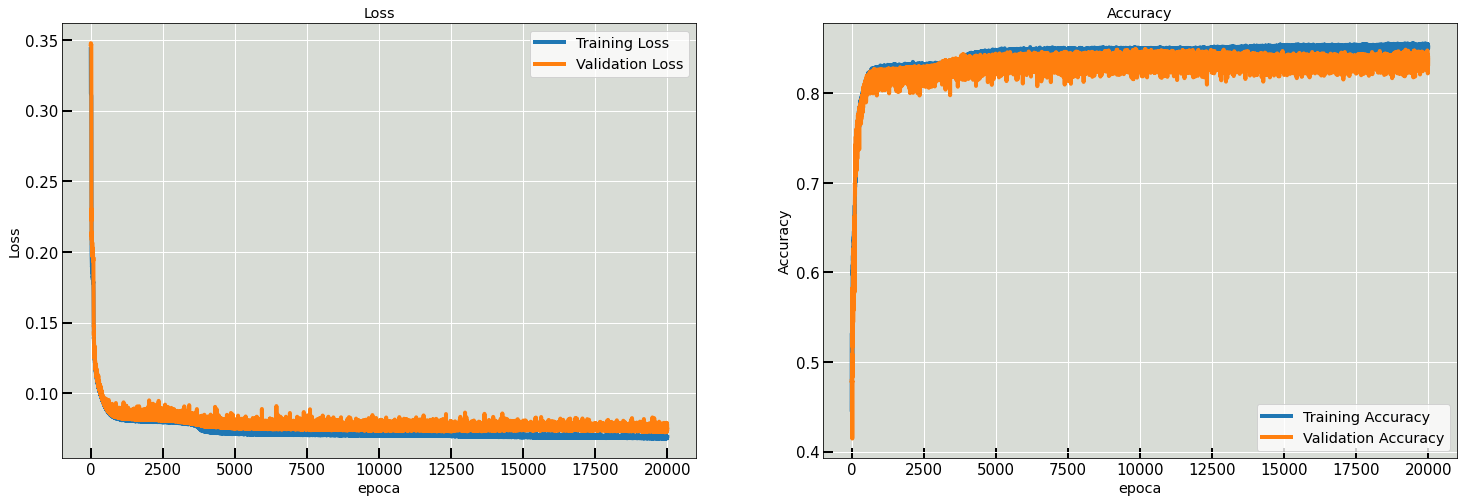

In [59]:
model = dos_capasOH(7,15)
history = model.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=20000)


fig, ax = plt.subplots(1,2,figsize=(25,8))
format(ax)
ax[0].set_ylabel('Loss',fontsize='x-large')
ax[0].set_xlabel('epoca',fontsize='x-large')
ax[0].plot(history.history['loss'], label='Training Loss', linewidth=4)
ax[0].plot(history.history['val_loss'], label='Validation Loss', linewidth=4)
ax[0].set_title(r"Loss",fontsize='x-large')
ax[0].legend(fontsize='x-large')

ax[1].set_ylabel('Accuracy',fontsize='x-large')
ax[1].set_xlabel('epoca',fontsize='x-large')
ax[1].plot(history.history['accuracy'], label='Training Accuracy',linewidth=4)
ax[1].plot(history.history['val_accuracy'], label='Validation Accuracy',linewidth=4)
ax[1].set_title(r"Accuracy",fontsize='x-large')
ax[1].legend(fontsize='x-large')

Bueno el overfiting está muy lejos. Además vemos que pareciera que si ponemos 5000 epocas llegaremos a lo máximo que podemos llegar que es alrededor de un 85%.

## Ensemble

Ahora vamos armarnos el ensemble, pero para asegurarnos de no tener problemas con la no evolución vamos a hacer que si los accuracys son menores que un 80% lo descartamos. El ensemble no va a poder ser muy grande por el tiempo computacional.

In [14]:
class dos_capasOH:
    def __init__(self, n1, n2):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(n2,activation='relu'))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000): 
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=1000)])
        return history    
    def set_weights_and_biases(self, w0, b0, w1, b1, w2, b2):
        self.model.layers[0].set_weights([w0, b0])
        self.model.layers[1].set_weights([w1, b1])
        self.model.layers[2].set_weights([w2, b2])
    def test(self, X, Y):
        self.model.evaluate(X,Y,verbose=0)

In [15]:
w0s = np.zeros((18,7))
w1s = np.zeros((7,15))
w2s = np.zeros((15,3))

b0s = np.zeros(7)
b1s = np.zeros(15)
b2s = np.zeros(3)

accuracys = []
count = 0
models = []

In [16]:
for i in range(150):
    print(f"Iteración {i+1}")
    model = dos_capasOH(7,15)
    history = model.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=5000)
    if history.history['val_accuracy'][-1] > 0.8:
        
        count += 1
        accuracys.append(history.history['val_accuracy'][-1])
        models.append(model)
        w0=model.model.layers[0].get_weights()[0]
        w1=model.model.layers[1].get_weights()[0]
        w2=model.model.layers[2].get_weights()[0]

        b0=model.model.layers[0].get_weights()[1]
        b1=model.model.layers[1].get_weights()[1]
        b2=model.model.layers[2].get_weights()[1]
        
        w0s += w0
        w1s += w1
        w2s += w2
        
        b0s += b0
        b1s += b1
        b2s += b2

Iteración 1
Epoch 1: loss = 0.31178757548332214, val_loss = 0.3457820415496826, acc=0.5313076972961426, val_acc = 0.4791542589664459
Epoch 1000: loss = 0.07905803620815277, val_loss = 0.08397138118743896, acc=0.8325384855270386, val_acc = 0.8180464506149292
Epoch 2000: loss = 0.07556448876857758, val_loss = 0.08191537111997604, acc=0.8397692441940308, val_acc = 0.8266825675964355
Epoch 3000: loss = 0.0750880315899849, val_loss = 0.08046802133321762, acc=0.8388461470603943, val_acc = 0.8260869383811951
Epoch 4000: loss = 0.07369689643383026, val_loss = 0.07955563068389893, acc=0.8433076739311218, val_acc = 0.8302561044692993
Epoch 5000: loss = 0.0745028629899025, val_loss = 0.07895781099796295, acc=0.8431538343429565, val_acc = 0.835616409778595
Iteración 2
Epoch 1: loss = 0.25708287954330444, val_loss = 0.2693512737751007, acc=0.5067692399024963, val_acc = 0.46783798933029175
Epoch 1000: loss = 0.0804552212357521, val_loss = 0.08447463065385818, acc=0.8296923041343689, val_acc = 0.8213

In [17]:
w0_prom = w0s/count
w1_prom = w1s/count
w2_prom = w2s/count
b0_prom = b0s/count
b1_prom = b1s/count
b2_prom = b2s/count

In [18]:
ensemble_model = dos_capasOH(7,15)
ensemble_model.set_weights_and_biases(w0_prom,b0_prom,w1_prom,b1_prom,w2_prom,b2_prom)
final_loss, final_acc = ensemble_model.model.evaluate(X,Y_ohfinal)
print(f"Loss = {final_loss}; Accuracy = {final_acc}")

512/512 [==============================] - 1s 843us/step - loss: 0.8679 - accuracy: 0.5207
Loss = 0.8678812384605408; Accuracy = 0.5206626653671265


Bueno evidentemente no funcionó, el accuracy bajo muchísimo. Una razón que se me ocurre es que en realidad estamos en muchos mínimos locales distintos y no llegamos a un verdadero mínimo, por lo que el promedio no tiene una significancia real.

## Entrenamiento muy largo

Vamos a finalizar entonces haciendo un modelo que vamos a entrenar realmente por muchas épocas y ver si de esta manera podemos mejorar el accuracy.

In [14]:
class dos_capasOH:
    def __init__(self, n1, n2):
        self.model = Sequential()
        self.model.add(Dense(n1,input_dim=18,activation='relu'))
        self.model.add(Dense(n2,activation='relu'))
        self.model.add(Dense(3,activation='softmax'))
        self.model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    def train(self, X_train, Y_train, X_test, Y_test, epochs=10, batch_size=1000): 
        history = self.model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_test, Y_test), verbose=0, callbacks=[PrintEveryN(n=1000)])
        return history    
    def set_weights_and_biases(self, w0, b0, w1, b1, w2, b2):
        self.model.layers[0].set_weights([w0, b0])
        self.model.layers[1].set_weights([w1, b1])
        self.model.layers[2].set_weights([w2, b2])
    def test(self, X, Y):
        self.model.evaluate(X,Y,verbose=0)

In [ ]:
modelo_final = dos_capasOH(7,15)
history_final = modelo_final.train(X_train, Y_trainoh, X_test, Y_testoh, epochs=800000)

Epoch 1: loss = 0.5124390125274658, val_loss = 0.4896564781665802, acc=0.23084615170955658, val_acc = 0.2653365135192871
Epoch 1000: loss = 0.08030544966459274, val_loss = 0.08160998672246933, acc=0.8301538228988647, val_acc = 0.8237046003341675
Epoch 2000: loss = 0.07870540767908096, val_loss = 0.08114467561244965, acc=0.8340769410133362, val_acc = 0.8269803524017334
Epoch 3000: loss = 0.07806357741355896, val_loss = 0.08005939424037933, acc=0.8365384340286255, val_acc = 0.8311495184898376
Epoch 4000: loss = 0.07908781617879868, val_loss = 0.08518575876951218, acc=0.8326153755187988, val_acc = 0.8156641125679016
Epoch 5000: loss = 0.07798846811056137, val_loss = 0.08261186629533768, acc=0.8353846073150635, val_acc = 0.8243001699447632
Epoch 6000: loss = 0.07696022093296051, val_loss = 0.08174390345811844, acc=0.8383076786994934, val_acc = 0.8263847231864929
Epoch 7000: loss = 0.07708460092544556, val_loss = 0.07818498462438583, acc=0.8380769491195679, val_acc = 0.8365098237991333
Epoc

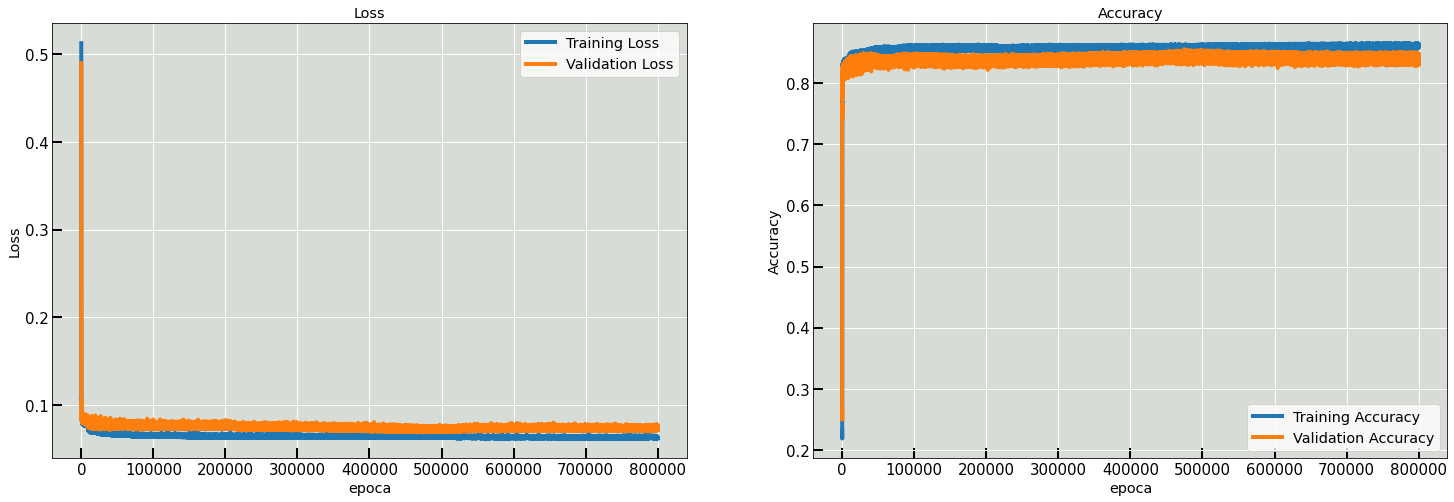

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(25,8))
format(ax)
ax[0].set_ylabel('Loss',fontsize='x-large')
ax[0].set_xlabel('epoca',fontsize='x-large')
ax[0].plot(history_final.history['loss'], label='Training Loss', linewidth=4)
ax[0].plot(history_final.history['val_loss'], label='Validation Loss', linewidth=4)
ax[0].set_title(r"Loss",fontsize='x-large')
ax[0].legend(fontsize='x-large')

ax[1].set_ylabel('Accuracy',fontsize='x-large')
ax[1].set_xlabel('epoca',fontsize='x-large')
ax[1].plot(history_final.history['accuracy'], label='Training Accuracy',linewidth=4)
ax[1].plot(history_final.history['val_accuracy'], label='Validation Accuracy',linewidth=4)
ax[1].set_title(r"Accuracy",fontsize='x-large')
ax[1].legend(fontsize='x-large')

No mejoró mucho más que las otras redes. De igual manera es la que mejor accuracy tiene así que este es nuestro modelo final.

In [20]:
w0f=modelo_final.model.layers[0].get_weights()[0]
w1f=modelo_final.model.layers[1].get_weights()[0]
w2f=modelo_final.model.layers[2].get_weights()[0]
b0f=modelo_final.model.layers[0].get_weights()[1]
b1f=modelo_final.model.layers[1].get_weights()[1]
b2f=modelo_final.model.layers[2].get_weights()[1]

np.savetxt("w0f.txt", w0f, delimiter= ' ', newline='\n')
np.savetxt("w1f.txt", w1f, delimiter= ' ', newline='\n')
np.savetxt("w2f.txt", w2f, delimiter= ' ', newline='\n')
np.savetxt("b0f.txt", b0f, delimiter= ' ', newline='\n')
np.savetxt("b1f.txt", b1f, delimiter= ' ', newline='\n')
np.savetxt("b2f.txt", b2f, delimiter= ' ', newline='\n')

## Conclusiones finales

Logramos entrenar un modelo que predice el grado de riesgo de tener un ACV utilizando datos médicos previos. Obtuvimos un accuracy alto de alrededor de 85% , sin embargo pareciera que nos encontramos con algún problema de mínimos locales que impide que las redes mejoren mas allá de este valor.